<a href="https://colab.research.google.com/github/garimamalhotra/Data-science/blob/master/Basketball_Data_Madness_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from scipy import stats

import matplotlib as mpl
from sklearn.svm import SVC
from tensorflow import keras
from scipy.stats import norm 
from sklearn.metrics import auc
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from keras.models import Sequential
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from keras.utils import to_categorical
from sklearn.utils import class_weight

from tensorflow.keras import regularizers
from keras.layers import Dense, Activation
from sklearn.naive_bayes import GaussianNB
from tensorflow.python.ops import math_ops
from tensorflow.keras.metrics import Recall
from sklearn.feature_selection import RFECV

from sklearn.metrics import auc as auc_value
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, KFold
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import accuracy_score, balanced_accuracy_score, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV

Using TensorFlow backend.


In [2]:
!pip install ipdb
import ipdb
!pip install gap-stat
from gap_statistic import OptimalK

Fix random seeds.

In [0]:
SEED = 42


os.environ['PYTHONHASHSEED'] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)
#tf.set_random_seed(SEED)
tf.random.set_seed(SEED)

Read in all the data files.

In [0]:
game_df = pd.read_csv('/content/ncaa-michigan-game-data.csv')
catapult_df = pd.read_csv("/content/michigan-catapult-data.csv")
season_df = pd.read_csv("/content/ncaa-michigan-season-data.csv")

In [5]:
game_df.head()

game_id  ...  opp_coach_tech_fouls
0  73ca9ce7-aec9-45bf-8939-88e137b3516f  ...                   0.0
1  4bba5bcf-821e-4aa4-8be9-752d1c0ff17b  ...                   0.0
2  aa5c4847-515c-4a10-a681-a823a1732c87  ...                   0.0
3  b2ff2eb9-56e9-4e88-94be-d88e911d37bb  ...                   0.0
4  56530d50-8c8e-4b7b-9c34-b53eacd36e31  ...                   NaN

[5 rows x 116 columns]

In [6]:
catapult_df.head()

Unnamed: 0  ... Player Load Band 4 Total Duration
0           0  ...                          00:01:56
1           1  ...                          00:00:00
2           2  ...                          00:02:13
3           3  ...                          00:01:10
4           4  ...                          00:05:21

[5 rows x 35 columns]

In [7]:
season_df.head()

TEAM CONF   G   W  ADJOE  ADJDE  ...  3P_D  ADJ_T  WAB  POSTSEASON  SEED  YEAR
0  Michigan  B10  38  26  123.3   97.6  ...  37.8   64.0  3.8         S16     7  2017
1  Michigan  B10  40  33  114.4   90.4  ...  33.2   65.9  6.9         2ND     3  2018

[2 rows x 24 columns]

In [0]:
catapult_df = catapult_df.rename(columns={'Unnamed: 0': 'serial_number'})

def convert_date(orig_date):
    x = orig_date.strftime('%m-%d-%Y')
    x_s = x.split("-")
    return x_s[0].lstrip("0").replace(" 0", " ") + "/" + x_s[1].lstrip("0").replace(" 0", " ") + "/" + x_s[2][2:]

catapult_df['scheduled_date'] = pd.to_datetime(catapult_df['Date'], format='%m/%d/%Y').apply(convert_date)

In [0]:
def add_to_date(date, days_to_add):
  d = datetime.datetime.strptime(date, '%m/%d/%y') + datetime.timedelta(days=days_to_add)
  x_s = d.strftime('%m/%d/%y').split("/")
  return x_s[0].lstrip("0").replace(" 0", " ") + "/" + x_s[1].lstrip("0").replace(" 0", " ") + "/" + x_s[2]

In [0]:
catapult_df['game'] = catapult_df['Period Name'].str.contains("Game")
catapult_df['practice'] = catapult_df['Period Name'].str.contains("Practice")
catapult_df['activity'] = catapult_df['Period Name'].str.contains("Activity")

Merge games and catapult data.

In [0]:
catapult_df_games = catapult_df
catapult_df_games['keep'] = False

params_to_copy = ['win', 'points_game']
values = [False, np.nan]

for param, value in zip(params_to_copy, values):
  catapult_df_games[param] = value

for i, row in catapult_df_games.iterrows():
  if not row['game']:
    continue

  if "LSU" in row['Period Name']:
    game_entry_for_this_catapult_game = game_df.loc[game_df['game_id'] == "6fe40efa-123b-4eaa-bbf6-648430b0447b"]
    catapult_df_games.at[i, 'keep'] = True
  elif "Chamminade" in row['Period Name']:
    game_entry_for_this_catapult_game = game_df.loc[game_df['game_id'] == "fb42a9db-904b-4847-afac-ee69d02597d7"]
    catapult_df_games.at[i, 'keep'] = True
  elif "VCU" in row['Period Name']:
    game_entry_for_this_catapult_game = game_df.loc[game_df['game_id'] == "1b7c1ba9-f960-4f1b-9600-6e27f196e00a"]
    catapult_df_games.at[i, 'keep'] = True
  else:

    game_entry_for_this_catapult_game = game_df.loc[game_df['scheduled_date'] == row['scheduled_date']]

    if (len(game_entry_for_this_catapult_game)) == 0:
      # Try an adjacent date.
      adjacent_date = add_to_date(row['scheduled_date'], 1)
      game_entry_2 = game_df.loc[game_df['scheduled_date'] == adjacent_date]

      if len(game_entry_2) == 0:
        catapult_df_games.at[i, 'keep'] = False
      else:
        game_entry_for_this_catapult_game = game_entry_2
        catapult_df_games.at[i, 'keep'] = True

    else:
      catapult_df_games.at[i, 'keep'] = True

  if catapult_df_games.at[i, 'keep']:
    for param in params_to_copy:
      catapult_df_games.at[i, param] = game_entry_for_this_catapult_game.iloc[0][param]

Convert date and times to timestamps to make comparisons easier.

In [0]:
def get_timestamp(t):
  return time.mktime(datetime.datetime.strptime(t, "%m/%d/%y %H:%M:%S").timetuple())

catapult_df_games['start_timestamp'] = (catapult_df_games['scheduled_date'] + " " + catapult_df_games['Start Time']).apply(get_timestamp)
catapult_df_games['end_timestamp'] = (catapult_df_games['scheduled_date'] + " " + catapult_df_games['End Time']).apply(get_timestamp)

def get_time(t):
  (h, m, s) = t.split(':')
  return int(h) * 3600 + int(m) * 60 + int(s)


time_vars = ['Total Instructional', 'Low Intensity Movement', 'Player Load Band 3 Total Duration', 'Player Load Band 4 Total Duration']

for time_var in time_vars:
  catapult_df_games[time_var + ' Seconds'] = catapult_df_games[time_var].apply(get_time)

In [13]:
features_to_use = ['Total Player Load', 'IMA Accel Low', 'Total IMA', 'Total Jumps', 'IMA Accel Medium', 'IMA Accel High', \
                 'IMA Decel Low', 'IMA Decel Medium', 'IMA Decel High', 'IMA CoD Left Low', 'IMA CoD Left Medium', \
                 'IMA CoD Left High', 'IMA CoD Right Low', 'IMA CoD Right Medium', 'IMA CoD Right High', \
                 'IMA Jump Count Low Band', 'IMA Jump Count Med Band', 'IMA Jump Count High Band', 'Rest Load', \
                 'Player Load Band 2 Total Player Load', 'High Intensity Movement', 'Player Load Band 4 Total Player Load', \
                 'Total Instructional Seconds', 'Low Intensity Movement Seconds', 'Player Load Band 3 Total Duration Seconds', \
                 'Player Load Band 4 Total Duration Seconds']

print(len(features_to_use))

26


Replace 0 entries with median values for that particular activity.

In [0]:
all_periods = catapult_df_games['Period Name'].unique()
all_features_median = {key:'median' for key in features_to_use}
catapult_df_games_means_by_period_names = catapult_df_games[catapult_df_games['Total Player Load'] != 0].groupby('Period Name').agg(all_features_median)

In [0]:
catapult_df_games['delete'] = False

for index, row in catapult_df_games.iterrows():
  if row['Total Player Load'] == 0:
    period_name = row['Period Name']
    try:
      median = catapult_df_games_means_by_period_names.loc[period_name]
      for feat in features_to_use:
        catapult_df_games.at[index, feat] = median[feat]
    except:
      catapult_df_games.at[index, 'delete'] = True


catapult_df_games = catapult_df_games[~catapult_df_games['delete']]
catapult_df_games_mean_stats = catapult_df_games.groupby('Period Name').agg({'mean'})
catapult_df_games_only = catapult_df_games[(catapult_df_games['keep']) & (catapult_df_games['game'])]

#### Histogram Total Player Load for all players.

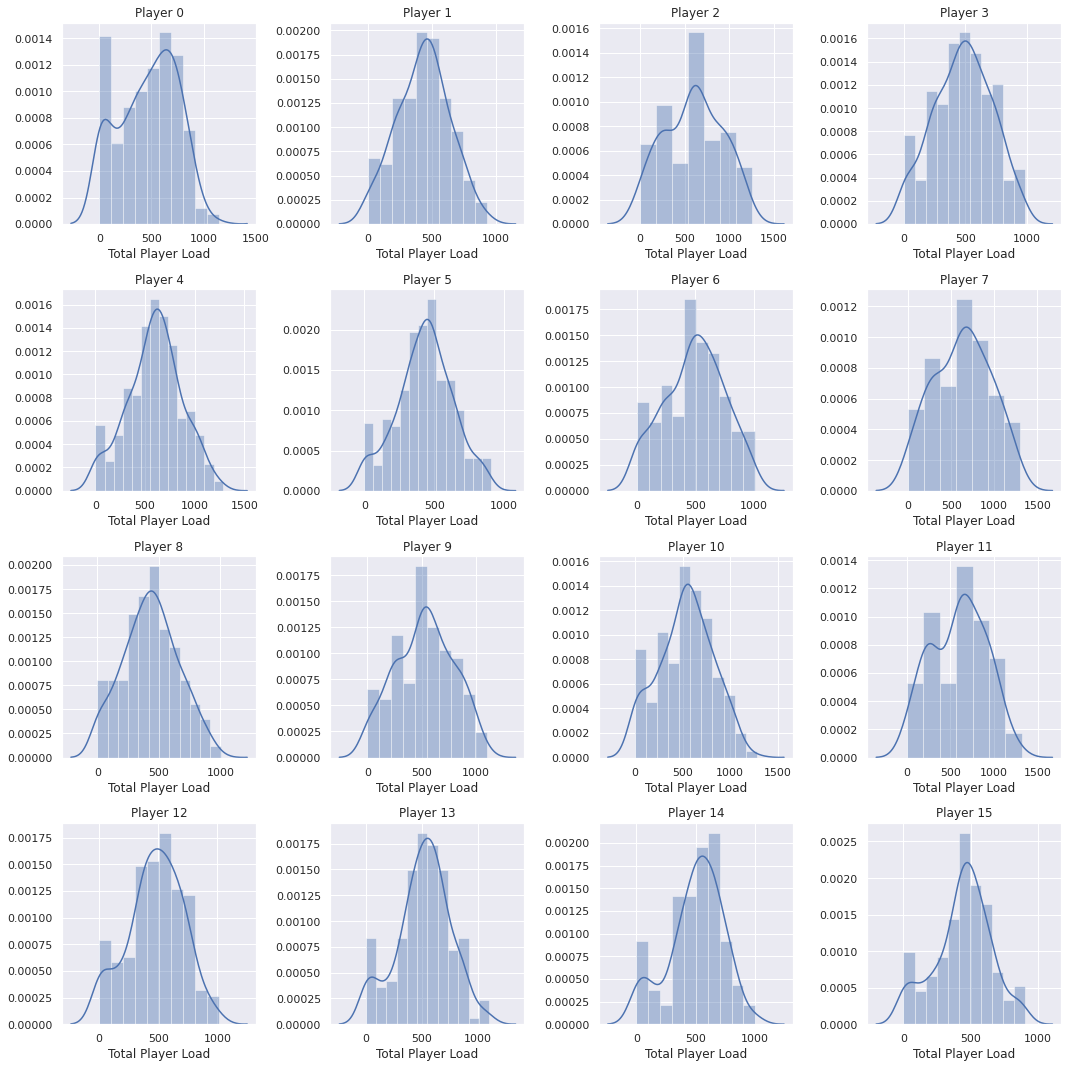

In [16]:
all_players = catapult_df_games['Player ID'].unique()

sns.set()
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
for i, player in enumerate(all_players):
    player_df = catapult_df_games.loc[catapult_df_games['Player ID'] == player]
    plt.subplot2grid((4, 4), (int(i/4), (i % 4)))
    sns.distplot(player_df['Total Player Load'])
    plt.title("Player " + str(i))
plt.tight_layout()

Adjusting for sample size, there doesn't seem to be something drastically different between all the player's Total Player Load.

#### Histogram by positions.

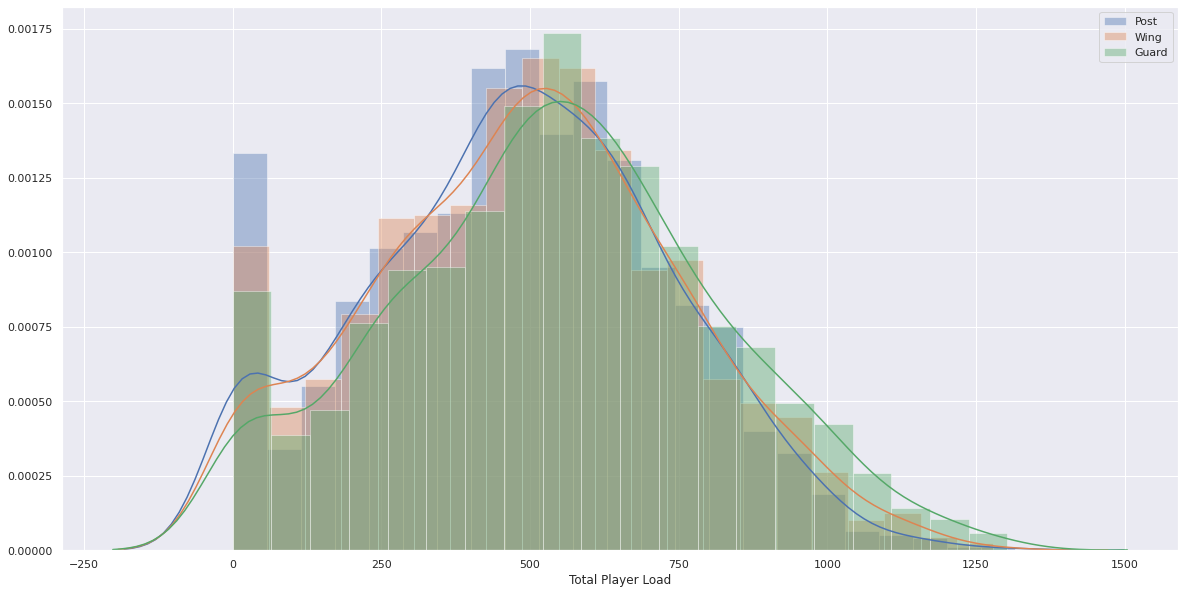

In [17]:
all_pos = catapult_df['Position Name'].unique()

plt.figure(figsize=(20,10))
sns.distplot(catapult_df.loc[catapult_df['Position Name'] == "Post"]['Total Player Load'], label="Post")
sns.distplot(catapult_df.loc[catapult_df['Position Name'] == "Wing"]['Total Player Load'], label="Wing")
sns.distplot(catapult_df.loc[catapult_df['Position Name'] == "Guard"]['Total Player Load'], label="Guard")

plt.legend()

#### Look at games leading up to 4 games on 4 days in 2017.

In [0]:
# Find the date of the end of the 4 games on 4 days.

four_on_four_start_time = catapult_df_games[catapult_df_games['Period Name'] == "Game-vs-Illinois-BTT"].iloc[0]['start_timestamp']
four_on_four_end_time = catapult_df_games[catapult_df_games['Period Name'] == "Game-vs-Wisconsin-BTT"].iloc[0]['end_timestamp']

feb_1_start_time = catapult_df_games[catapult_df_games['Period Name'] == "Team-Practice--Feb-1--2017"].iloc[0]['end_timestamp']

In [0]:
avg_var = 'mean'

games_before_four_on_four = catapult_df_games.loc[(catapult_df_games['start_timestamp'] >= feb_1_start_time) & (catapult_df_games['start_timestamp'] < four_on_four_start_time)]
games_before_four_on_four = games_before_four_on_four.sort_values('start_timestamp')
games_before_four_on_four_mean_stats = games_before_four_on_four.groupby('Period Name').agg({avg_var})

four_games_on_four_days = catapult_df_games.loc[(catapult_df_games['start_timestamp'] >= four_on_four_start_time) & (catapult_df_games['start_timestamp'] <= four_on_four_end_time)]
four_games_on_four_days_mean_stats = four_games_on_four_days.groupby('Period Name').agg({avg_var})

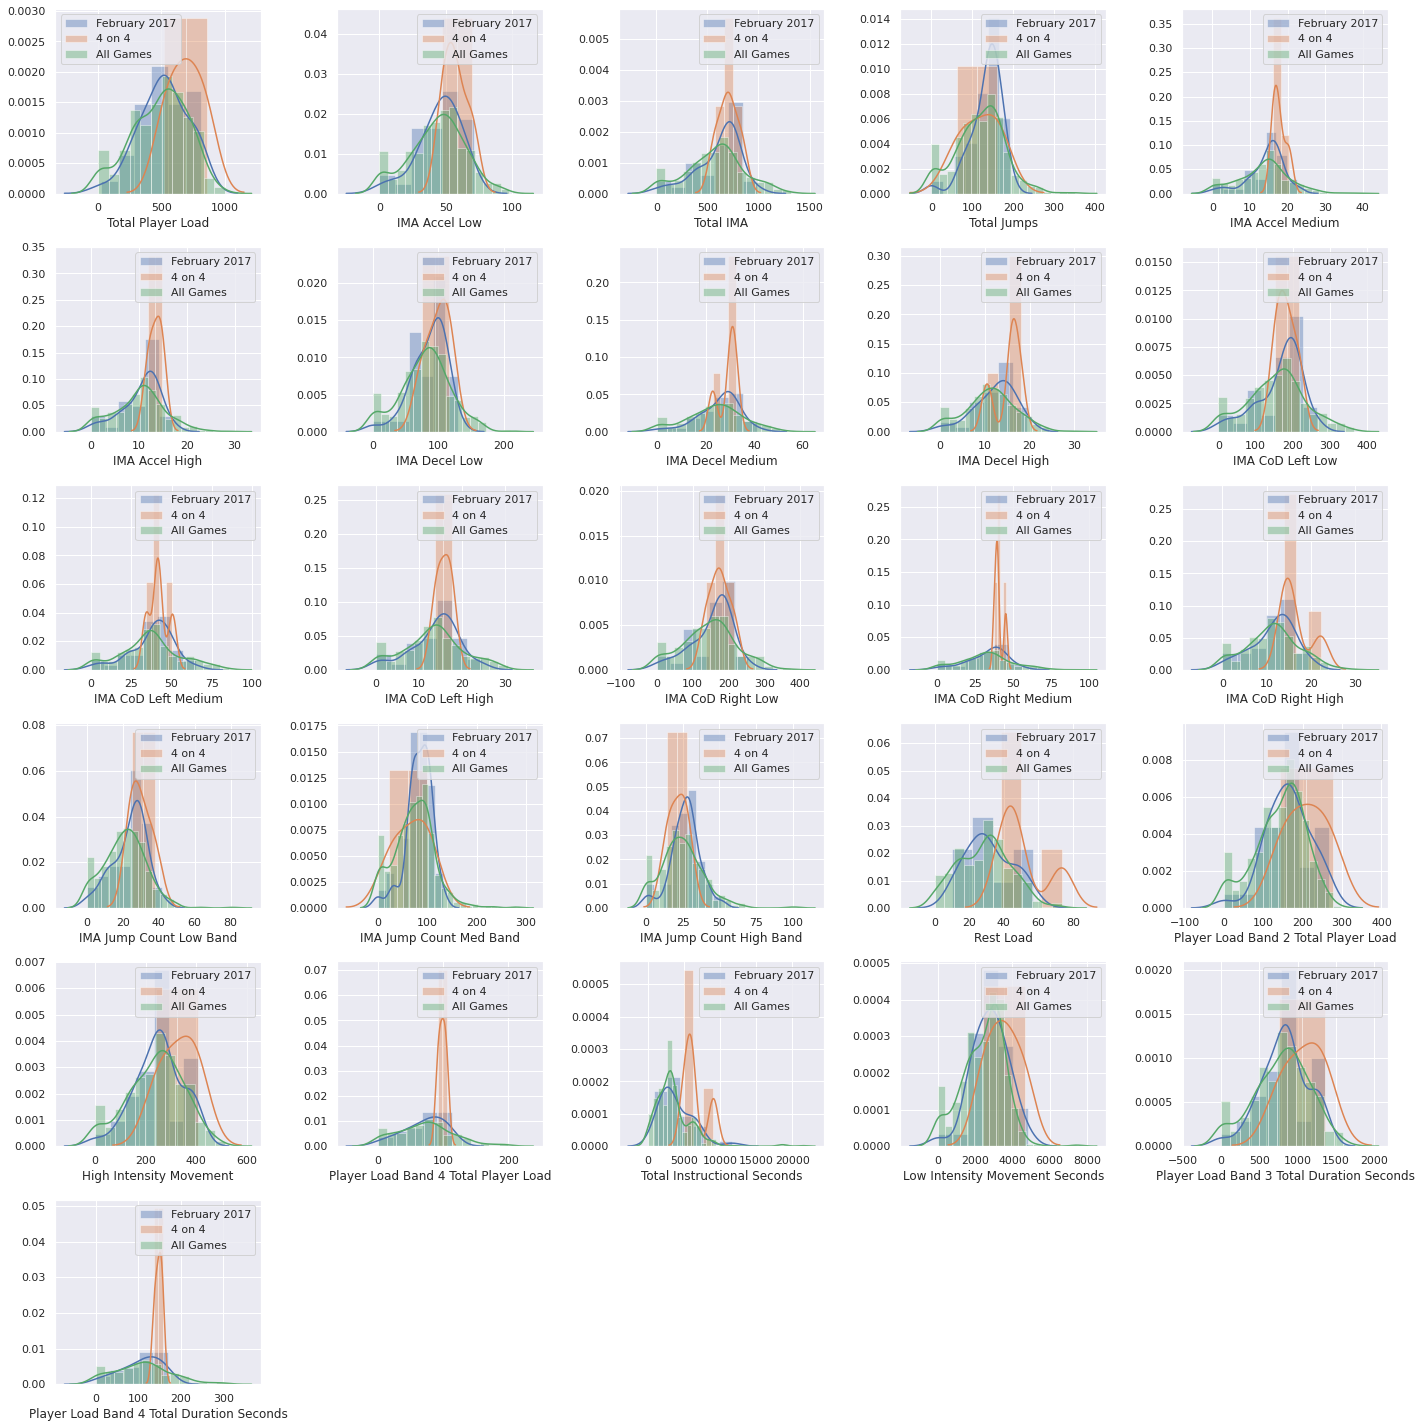

In [20]:
fig = plt.figure(figsize=(20, 20))

all_games_avg = catapult_df_games.groupby('Period Name').agg({avg_var})

for i in range(len(features_to_use)):
  var = features_to_use[i]
  fig.add_subplot(6, 5, i+1)
  sns.distplot(games_before_four_on_four_mean_stats[var][avg_var], label="February 2017")
  sns.distplot(four_games_on_four_days_mean_stats[var][avg_var], label="4 on 4")
  sns.distplot(all_games_avg[var][avg_var], label="All Games")
  plt.legend()
  plt.xlabel(var)

plt.tight_layout()

See if the differences in the distribution of Total Player Load are statistically significant.

In [21]:
def two_sample_t_test(alpha, a, b):
  s12 = np.var(a)
  s22 = np.var(b)
  n1 = len(a)
  n2 = len(b)

  SE = np.sqrt(s12 / n1 + s22 / n2) # Satterthwaite Approximation
  t_stat = (np.mean(b) - np.mean(a)) / SE

  dof_num = ((s12 / n1 + s22 / n2)**2)
  dof_den = ( ((s12 / n1)**2 / (n1 - 1)) + ((s22 / n2)**2 / (n2 - 1)) )
  dof = int(dof_num/dof_den)

  t_crit = stats.t.ppf(1 - 0.05, dof)
  p_value = stats.t.sf(np.abs(t_stat), dof)*2

  # Reject H_o (equal means) if p_value < alpha.
  # So p_value < alpha means means are not equal.

  equal_mean = p_value > alpha
  return t_crit, p_value, equal_mean

avg_var = 'mean'

print("Total Player Load")
print("February vs 4 on 4", two_sample_t_test(0.1, games_before_four_on_four_mean_stats['Total Player Load'][avg_var], four_games_on_four_days_mean_stats['Total Player Load'][avg_var]))
print("All games vs 4 on 4", two_sample_t_test(0.1, all_games_avg['Total Player Load'][avg_var], four_games_on_four_days_mean_stats['Total Player Load'][avg_var]))
print("February vs All", two_sample_t_test(0.1, all_games_avg['Total Player Load'][avg_var], games_before_four_on_four_mean_stats['Total Player Load'][avg_var]))

print()

print("Rest Load")
print("February vs 4 on 4", two_sample_t_test(0.1, games_before_four_on_four_mean_stats['Rest Load'][avg_var], four_games_on_four_days_mean_stats['Rest Load'][avg_var]))
print("All games vs 4 on 4", two_sample_t_test(0.1, all_games_avg['Rest Load'][avg_var], four_games_on_four_days_mean_stats['Rest Load'][avg_var]))
print("February vs All", two_sample_t_test(0.1, all_games_avg['Rest Load'][avg_var], games_before_four_on_four_mean_stats['Rest Load'][avg_var]))

Total Player Load
February vs 4 on 4 (2.13184678133629, 0.07226089711843657, False)
All games vs 4 on 4 (2.3533634348018264, 0.05087020343876549, False)
February vs All (1.681070701847763, 0.336133857786053, True)

Rest Load
February vs 4 on 4 (2.3533634348018264, 0.07054383537076762, False)
All games vs 4 on 4 (2.3533634348018264, 0.04595078804094327, False)
February vs All (1.681070701847763, 0.22835217922747203, True)


So we reject the null hypothesis that the expected total player load for four on four games is the same as the expected value for all other games or for the February games, at a 10% significance level.

In other words, at 10% significance level, there is evidence that the expected load for 4 on 4 is different from load in February and average load over all games. There is however not sufficient evidence that there is a difference in expected load for February vs all games.

### Look at the games ending in result Sweet Sixteen (2018).

In [0]:
sweet_16_start_time = catapult_df_games[catapult_df_games['Period Name'] == "Team-Practice--31--Nov-12--2016-day-after-game"].iloc[0]['start_timestamp']
sweet_16_end_time = catapult_df_games[catapult_df_games['Period Name'] == "Game-vs--Oregon"].iloc[0]['end_timestamp']

sweet_16_all = catapult_df_games.loc[(catapult_df_games['start_timestamp'] >= sweet_16_start_time) & (catapult_df_games['start_timestamp'] <= sweet_16_end_time)]

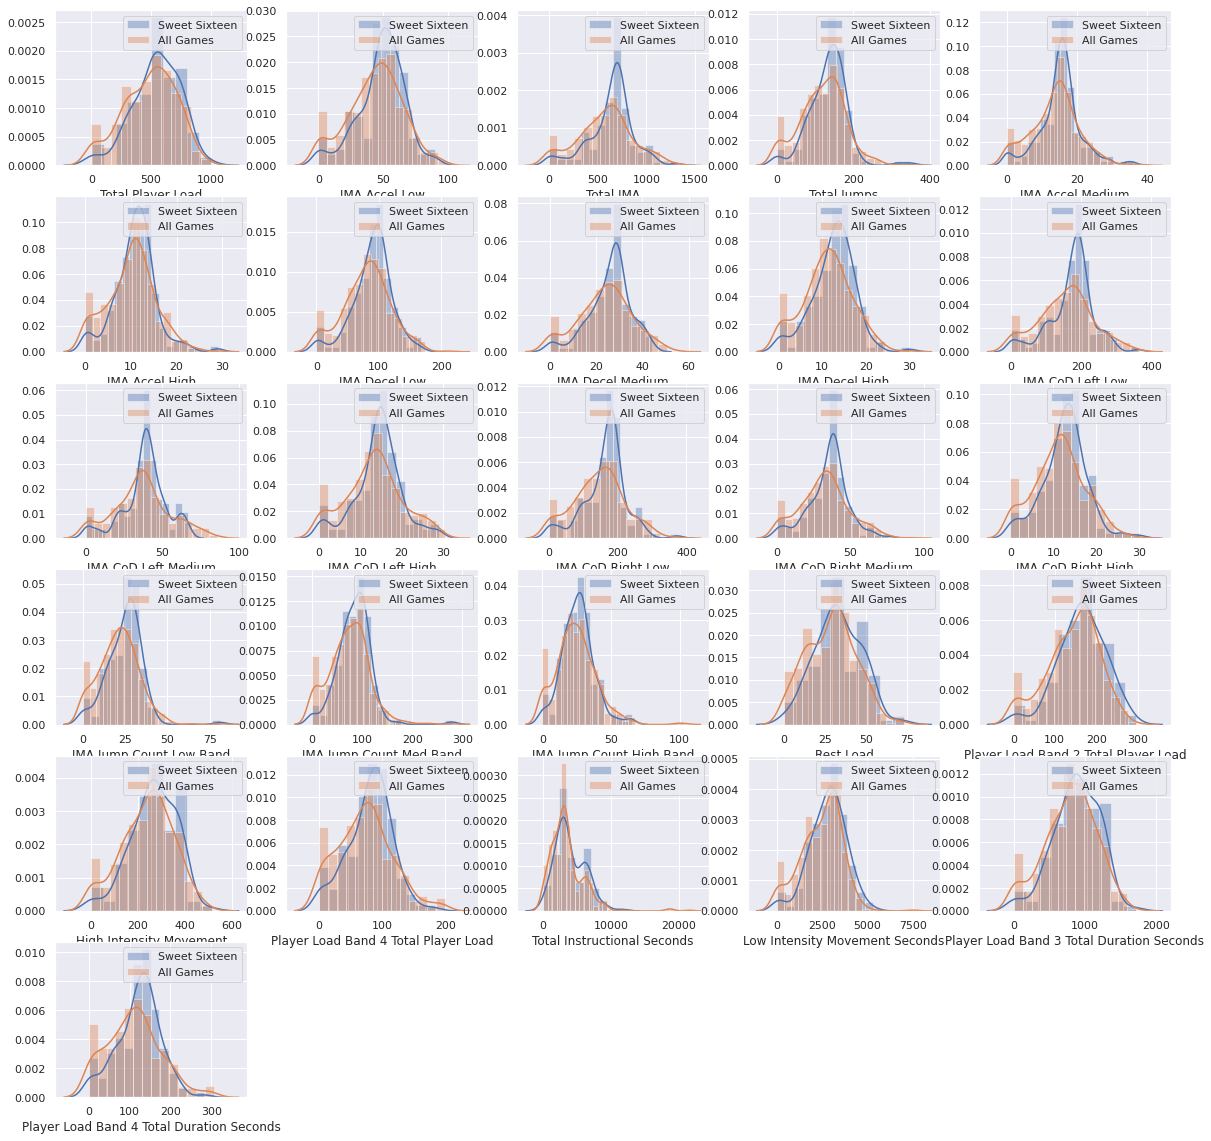

In [23]:
key = 'mean'

sweet_16_all = sweet_16_all.sort_values('start_timestamp')
sweet_16_all_mean_stats = sweet_16_all.groupby('Period Name').agg({key})

fig = plt.figure(figsize=(20, 20))

for i in range(len(features_to_use)):
  var = features_to_use[i]
  fig.add_subplot(6, 5, i+1)
  sns.distplot(sweet_16_all_mean_stats[var][key], label="Sweet Sixteen")
  sns.distplot(catapult_df_games_mean_stats[var][key], label="All Games")
  plt.legend()
  plt.xlabel(var)

It does not look like there is any statistically significant difference in the stats for sween sixteen vs other games.

### Look at the games ending in result Sweet Sixteen (2018) separated by game kind.

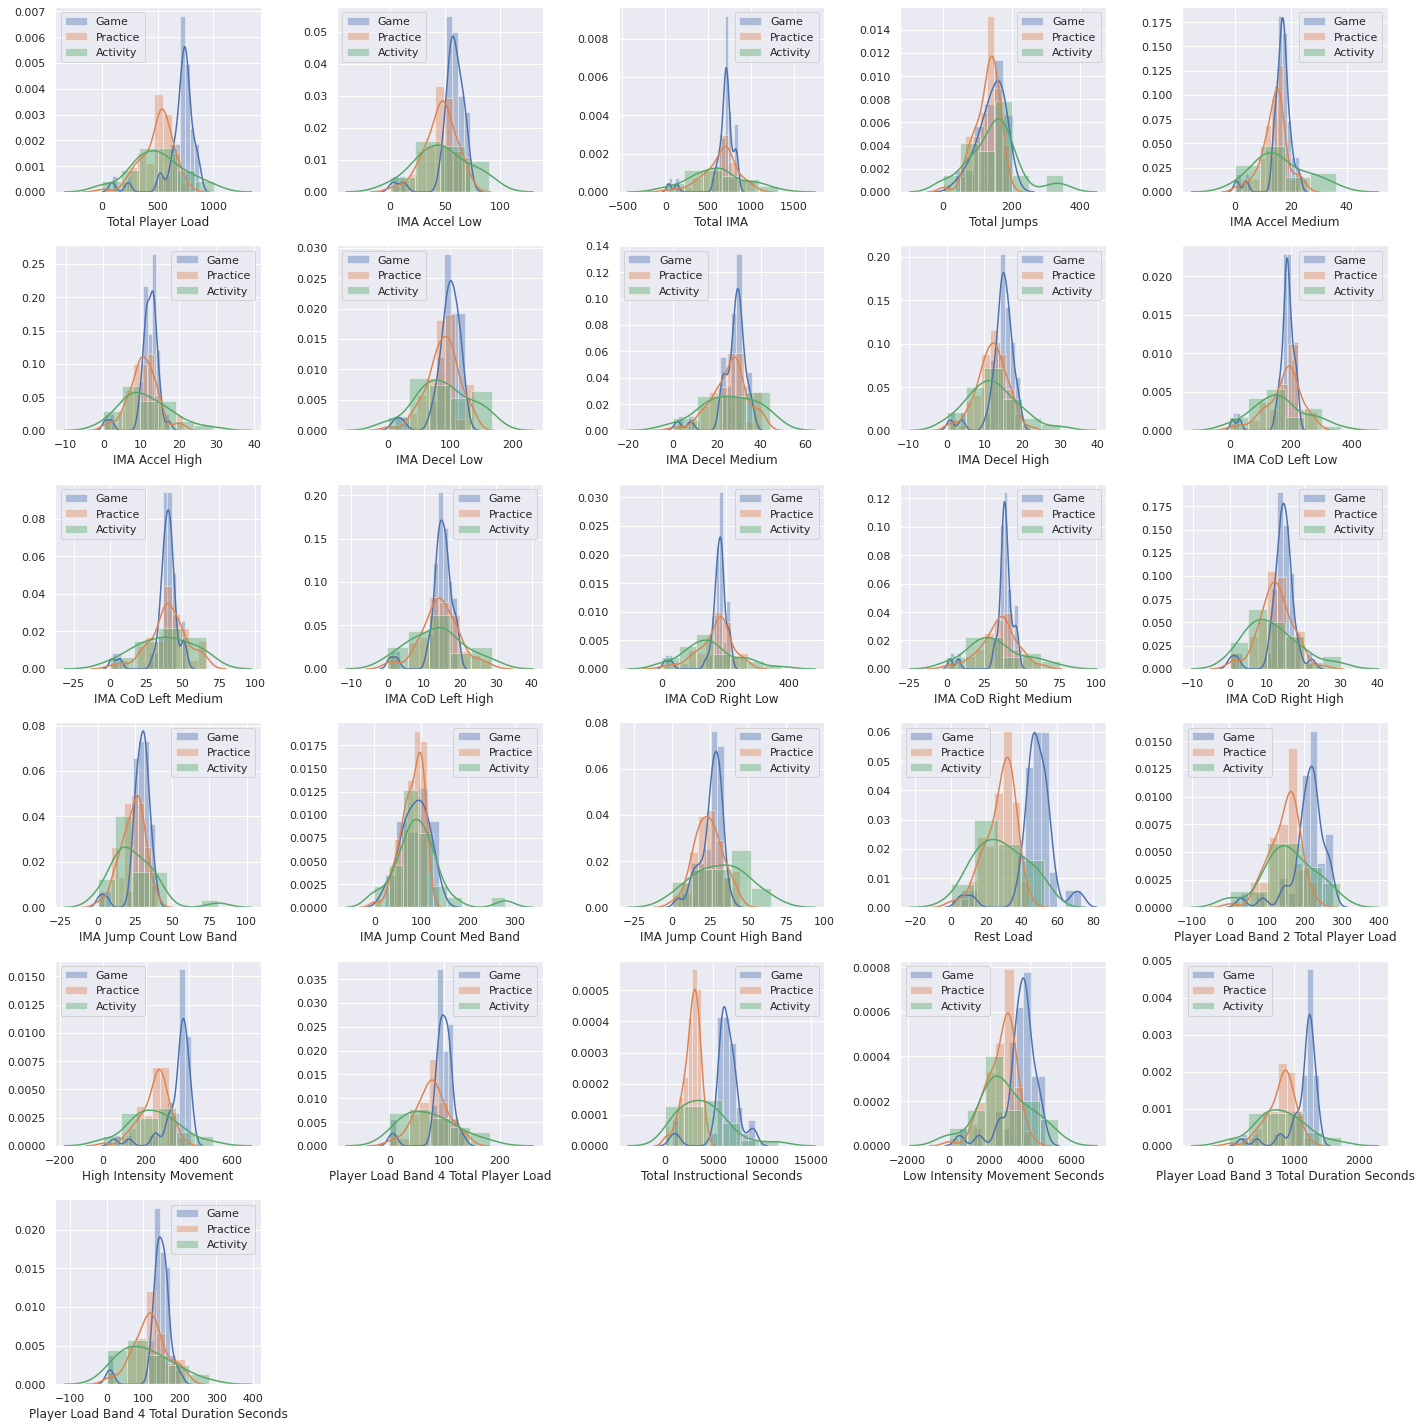

In [24]:
sweet_16_all_games = sweet_16_all.loc[sweet_16_all['Period Name'].str.contains("Game")]
sweet_16_all_practice = sweet_16_all.loc[sweet_16_all['Period Name'].str.contains("Practice")]
sweet_16_all_activity = sweet_16_all.loc[sweet_16_all['Period Name'].str.contains("Activity")]

key = 'mean'

sweet_16_all_games_stats = sweet_16_all_games.groupby('Period Name').agg({key})
sweet_16_all_practice_stats = sweet_16_all_practice.groupby('Period Name').agg({key})
sweet_16_all_activity_stats = sweet_16_all_activity.groupby('Period Name').agg({key})

fig = plt.figure(figsize=(20, 20))

for i in range(0, len(features_to_use)):
  var = features_to_use[i]
  fig.add_subplot(6, 5, i+1)
  sns.distplot(sweet_16_all_games_stats[var][key], label="Game")
  sns.distplot(sweet_16_all_practice_stats[var][key], label="Practice")
  sns.distplot(sweet_16_all_activity_stats[var][key], label="Activity")
  plt.xlabel(var)
  plt.legend()

plt.tight_layout() 

Check statistical significance.

In [25]:
avg_var = 'mean'

print("Total Player Load")
print("Games vs Activity", two_sample_t_test(0.1, sweet_16_all_games_stats['Total Player Load'][avg_var], \
                                             sweet_16_all_activity_stats['Total Player Load'][avg_var]))
print("Games vs Practice", two_sample_t_test(0.1, sweet_16_all_games_stats['Total Player Load'][avg_var], \
      sweet_16_all_practice_stats['Total Player Load'][avg_var]))
print("Activity vs Practice", two_sample_t_test(0.1, sweet_16_all_activity_stats['Total Player Load'][avg_var], \
                                                sweet_16_all_practice_stats['Total Player Load'][avg_var]))

print()
print("Rest Load")
print("Games vs Activity", two_sample_t_test(0.1, sweet_16_all_games_stats['Rest Load'][avg_var], \
                                             sweet_16_all_activity_stats['Rest Load'][avg_var]))
print("Games vs Practice", two_sample_t_test(0.1, sweet_16_all_games_stats['Rest Load'][avg_var], \
      sweet_16_all_practice_stats['Rest Load'][avg_var]))
print("Activity vs Practice", two_sample_t_test(0.1, sweet_16_all_activity_stats['Rest Load'][avg_var], \
                                                sweet_16_all_practice_stats['Rest Load'][avg_var]))

Total Player Load
Games vs Activity (1.6819523559426, 0.0003670827299089146, False)
Games vs Practice (1.6672385485425922, 4.066700460098731e-09, False)
Activity vs Practice (1.6909242507706543, 0.9592965234152644, True)

Rest Load
Games vs Activity (1.6746891532047905, 2.163129227852324e-07, False)
Games vs Practice (1.6720288881322787, 8.23186783085844e-13, False)
Activity vs Practice (1.6895724539637709, 0.8712932707490195, True)


So at 10% siginficant level, there is evidence that the expected load is different between games and activity as well as between games and practice. But there isn't sufficient evidence that the average load is different between practice and activity games. There is the same relationship between expected rest load between the three kinds of games.

## Inference

### See if there is a correlation between player load and win/loss

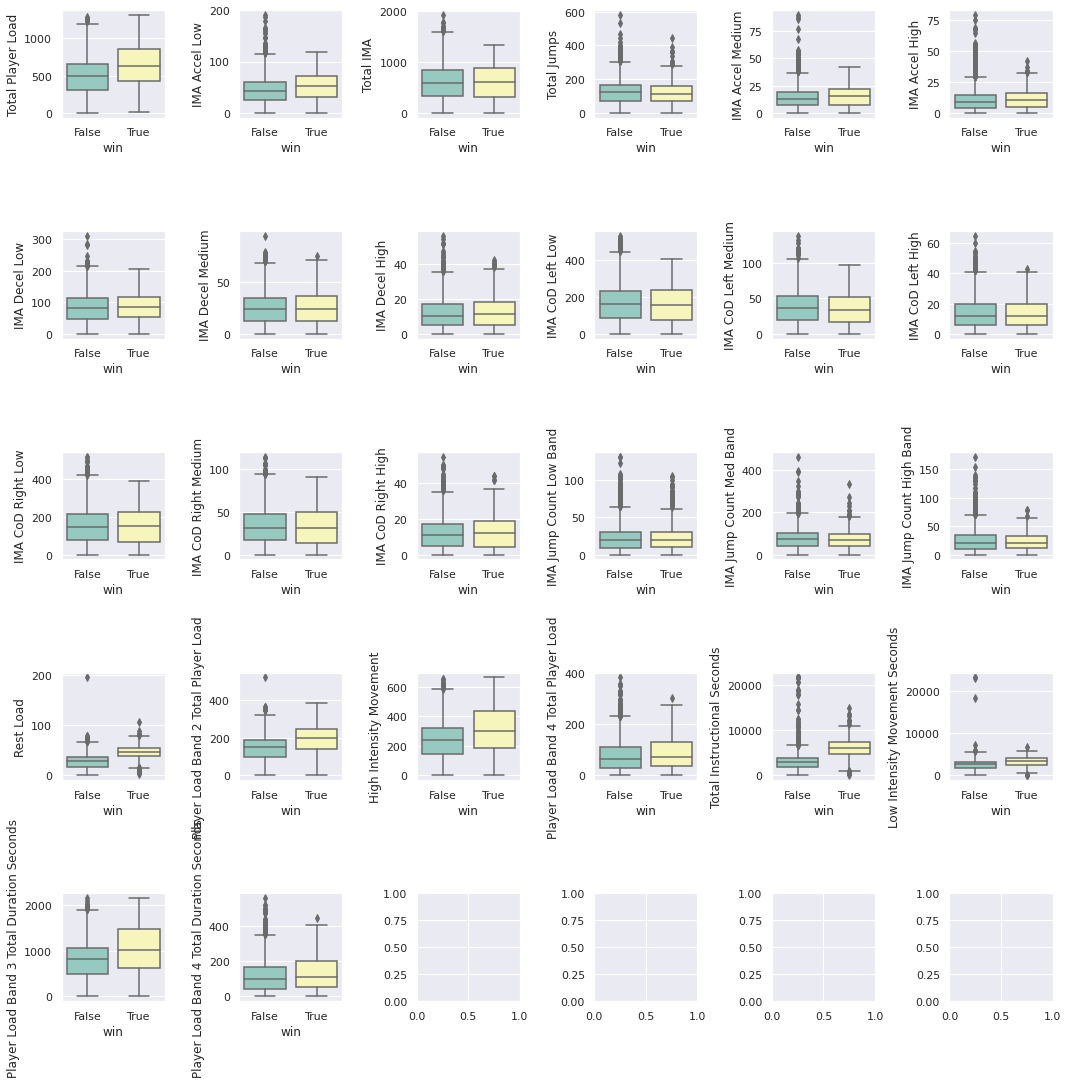

In [26]:

fig, axes = plt.subplots(5, 6, figsize=(15, 15))

axes = axes.flatten()


for i in range(len(features_to_use)):
  var = features_to_use[i]
  sns.boxplot(x="win", y=var, data=catapult_df_games, palette="Set3", ax=axes[i])
  

plt.tight_layout()

There seems to be some correlation between outocome and load but it seems very weak.

### Look at correlations between the features.

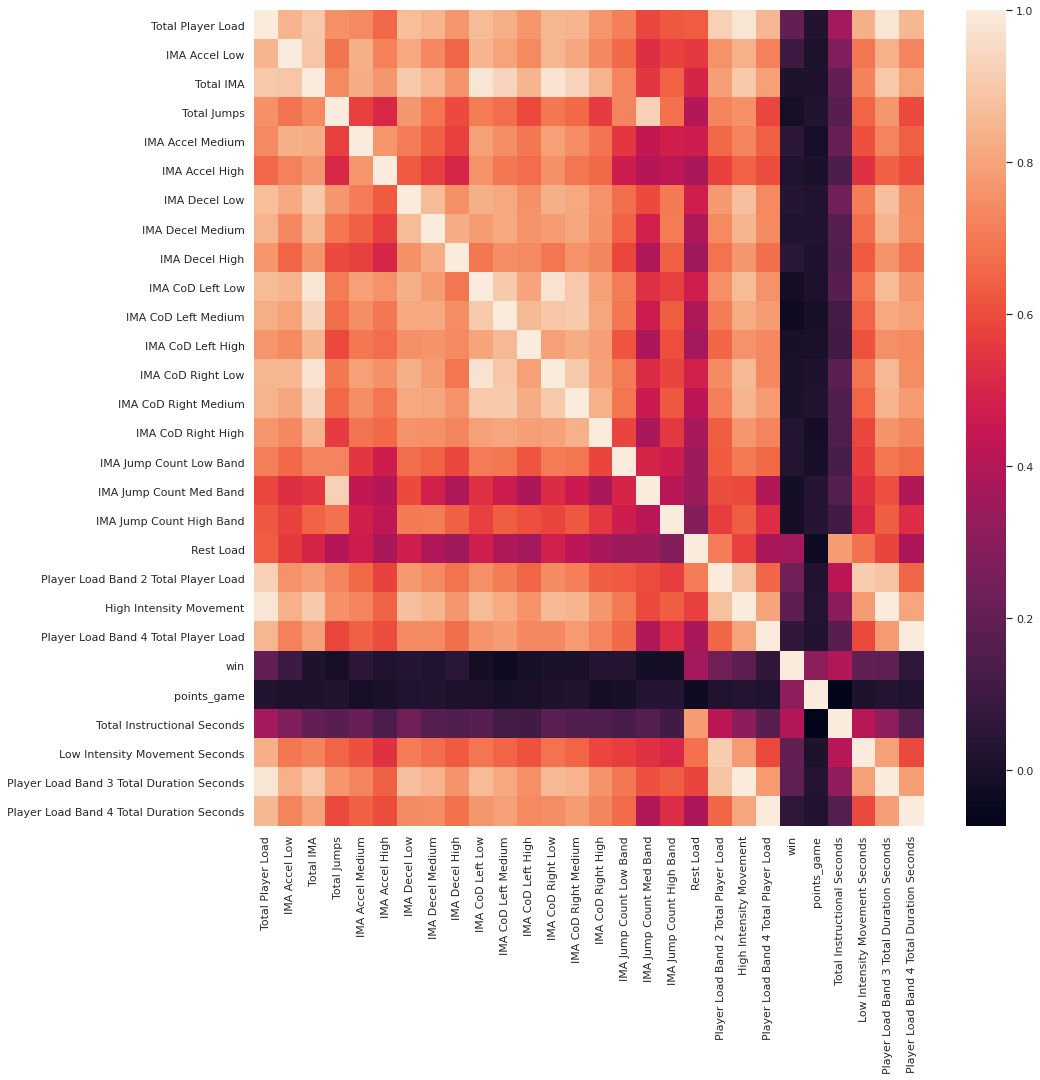

In [27]:
catapult_features_df = catapult_df_games.drop(['serial_number', 'game', 'practice', 'activity', 'start_timestamp',\
                                               'end_timestamp', 'keep', 'delete'], axis=1)


plt.figure(figsize=(15, 15))
sns.heatmap(catapult_features_df.corr(), annot=False)

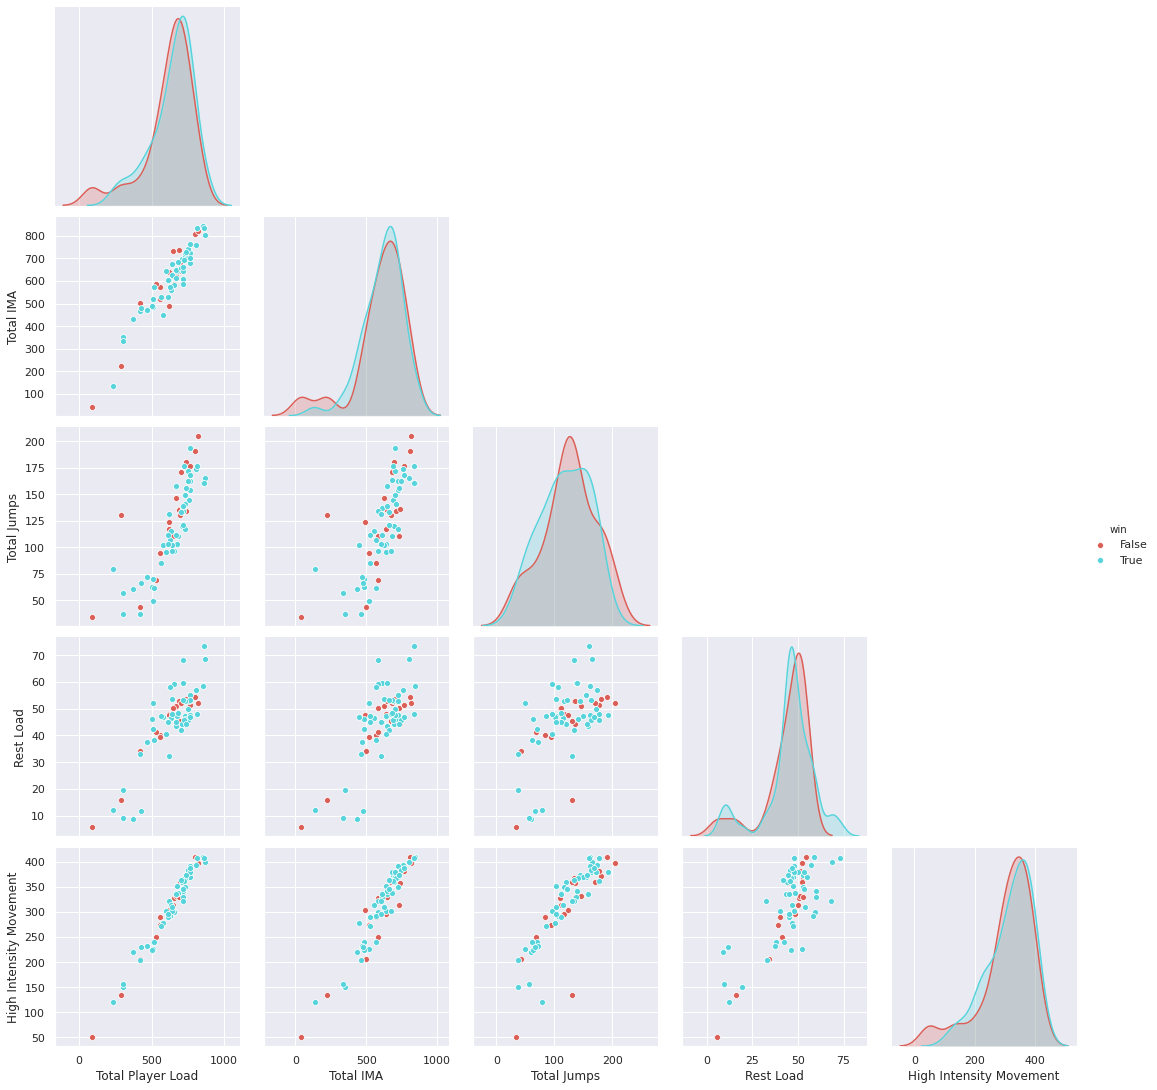

In [28]:
catapult_df_games_only_stats = catapult_df_games_only.groupby('Period Name').agg('mean').drop(['serial_number', 'game', \
                                                                                               'practice', 'activity', 'start_timestamp',\
                                                                                               'end_timestamp', 'keep', 'delete'], axis=1)
catapult_df_games_only_stats['win'] = catapult_df_games_only_stats['win'].apply(lambda x: x > 0.5)
features_to_use_for_pairwise = ['Total Player Load', 'Total IMA', 'Total Jumps', 'Rest Load', 'High Intensity Movement', 'win']

sns.set()
with sns.plotting_context("notebook",font_scale=1):
  g = sns.pairplot(catapult_df_games_only_stats[features_to_use_for_pairwise], corner=True, hue='win', palette='hls', height=3);

There seems to be a lot of interesting correlation but it's hard to see a discernible pattern in the differences between win and loss.

### Prepare data for classification algorithms.

Use cross-validation to tune the hyperparameters.
Also use cross-validated scores as metric.

In [29]:
x_raw = catapult_df_games_only[features_to_use]
y = catapult_df_games_only['win']

x_raw.head()

Total Player Load  ...  Player Load Band 4 Total Duration Seconds
801          685.90034  ...                                        127
802          342.52042  ...                                         11
803          782.42491  ...                                        172
804          955.68962  ...                                        218
805          776.27242  ...                                        125

[5 rows x 26 columns]

In [0]:
x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(x_raw, y, test_size=0.25)

scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform( x_train_unscaled[features_to_use] ), columns=features_to_use)
x_test = pd.DataFrame(scaler.transform( x_test_unscaled[features_to_use] ), columns=features_to_use)

#### XGBoost

In [31]:
model = XGBClassifier()
model.fit(x_train, y_train)

xgboost_cv_auc = cross_val_score(model, x_test, y_test, scoring='roc_auc', cv=5).mean()
xgboost_cv_f1 = cross_val_score(model, x_test, y_test, scoring='f1', cv=5).mean()
xgboost_cv_balanced_accuracy = cross_val_score(model, x_test, y_test, scoring='balanced_accuracy', cv=5).mean()

print("XGBoost CV AUC: %.2f" % xgboost_cv_auc)
print("XGBoost CV F1: %.2f" % xgboost_cv_f1)
print("XGBoost CV Balanced Accuracy: %.2f" % xgboost_cv_balanced_accuracy)

XGBoost CV AUC: 0.58
XGBoost CV F1: 0.84
XGBoost CV Balanced Accuracy: 0.59


Use Grid Search (instead of Exhaustive to save time) with cross-validation to tune hyperparameters.



In [32]:
search_for_best_params = False


param_dist = {'n_estimators': np.arange(1, 200, 2),
              'max_depth': np.arange(1, 10, 1),
              'booster': ['gbtree', 'gblinear', 'dart']
             }


best_params = {'booster': 'gbtree', 'max_depth': 7, 'n_estimators': 183}


if search_for_best_params:
    print("Searching for optimum hyperparameters.")
    xgboost_clf = GridSearchCV(model, param_grid=param_dist, cv=5, scoring='roc_auc', error_score=0, verbose=0, n_jobs=-1)
    xgboost_tuned_search = xgboost_clf.fit(x_train, y_train)
    
    print(xgboost_tuned_search.best_params_)
else:
    xgboost_tuned_search = XGBClassifier(**best_params).fit(x_train, y_train)

xgboost_cv_auc = cross_val_score(xgboost_tuned_search, x_test, y_test, scoring='roc_auc', cv=5).mean()
xgboost_cv_f1 = cross_val_score(xgboost_tuned_search, x_test, y_test, scoring='f1', cv=5).mean()
xgboost_cv_balanced_accuracy = cross_val_score(xgboost_tuned_search, x_test, y_test, scoring='balanced_accuracy', cv=5).mean()

print()
print("XGBoost CV ROC AUC: %.2f" % xgboost_cv_auc)
print("XGBoost CV F1: %.2f" % xgboost_cv_f1)
print("XGBoost CV Balanced Accuracy: %.2f" % xgboost_cv_balanced_accuracy)



XGBoost CV ROC AUC: 0.59
XGBoost CV F1: 0.83
XGBoost CV Balanced Accuracy: 0.59


### Logistic Regression

In [33]:
logistic_clf = LogisticRegression(random_state=42, max_iter=100, solver='liblinear', class_weight='balanced').fit(x_train, y_train)

logistic_cv_auc = cross_val_score(logistic_clf, x_test, y_test, scoring='roc_auc', cv=5).mean()
logistic_cv_f1 = cross_val_score(logistic_clf, x_test, y_test, scoring='f1', cv=5).mean()
logistic_cv_balanced_accuracy = cross_val_score(logistic_clf, x_test, y_test, scoring='balanced_accuracy', cv=5).mean()


print("Logistic Regression CV AUC: %.2f" % logistic_cv_auc)
print("Logistic Regression CV F1: %.2f" % logistic_cv_f1)
print("Logistic Regression CV Balanced Accuracy: %.2f" % logistic_cv_balanced_accuracy)

Logistic Regression CV AUC: 0.54
Logistic Regression CV F1: 0.67
Logistic Regression CV Balanced Accuracy: 0.52


Use Grid Search with cross-validation to tune hyperparameters.

In [34]:
search_for_best_params = False

param_dist = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': np.linspace(0.001, 2, 50)
             }

# Best params.
best_params = {'C': 1.877612244897959, 'penalty': 'l2'}



if search_for_best_params:
    print("Searching for optimum hyperparameters.")
    logistic_tuned_clf = GridSearchCV(logistic_clf, param_grid=param_dist, cv=5, scoring='roc_auc', \
                                            error_score=0, verbose=0, n_jobs=-1)
    logistic_tuned_search = logistic_tuned_clf.fit(x_train, y_train)
    
    print(logistic_tuned_search.best_params_)
    
else:
    logistic_tuned_search = LogisticRegression(**best_params).fit(x_train, y_train)

logistic_tuned_cv_auc = cross_val_score(logistic_tuned_search, x_test, y_test, scoring='roc_auc', cv=5).mean();
logistic_tuned_cv_f1 = cross_val_score(logistic_tuned_search, x_test, y_test, scoring='f1', cv=5).mean();
logistic_tuned_cv_balanced_accuracy = cross_val_score(logistic_tuned_search, x_test, y_test, scoring='balanced_accuracy', cv=5).mean();

print()
print("Logistic Regression Hyperparameter Tuned CV ROC AUC: %.2f" % logistic_tuned_cv_auc);
print("Logistic Regression Hyperparameter Tuned CV F1: %.2f" % logistic_tuned_cv_f1);
print("Logistic Regression Hyperparameter Tuned CV Balanced Accuracy: %.2f" % logistic_tuned_cv_balanced_accuracy);


Logistic Regression Hyperparameter Tuned CV ROC AUC: 0.53
Logistic Regression Hyperparameter Tuned CV F1: 0.83
Logistic Regression Hyperparameter Tuned CV Balanced Accuracy: 0.50


### Use Naive Bayes

In [35]:
naive_bayes_clf = GaussianNB().fit(x_train, y_train)

naive_bayes_cv_auc = cross_val_score(naive_bayes_clf, x_test, y_test, scoring='roc_auc', cv=5).mean()
naive_bayes_cv_f1_score = cross_val_score(naive_bayes_clf, x_test, y_test, scoring='f1', cv=5).mean()
naive_bayes_cv_balanced_accuracy_score = cross_val_score(naive_bayes_clf, x_test, y_test, scoring='balanced_accuracy', cv=5).mean()


print()
print("Naive Bayes Cross-Validation ROC AUC: %.2f" % naive_bayes_cv_auc)
print("Naive Bayes Cross-Validation F1: %.2f" % naive_bayes_cv_f1_score)
print("Naive Bayes Cross-Validation Balanced Accuracy: %.2f" % naive_bayes_cv_balanced_accuracy_score)


Naive Bayes Cross-Validation ROC AUC: 0.56
Naive Bayes Cross-Validation F1: 0.74
Naive Bayes Cross-Validation Balanced Accuracy: 0.55


### Use Random Forest.

In [36]:
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced').fit(x_train, y_train)

rf_cv_auc = cross_val_score(rf_clf, x_test, y_test, scoring='roc_auc', cv=5).mean()
rf_cv_f1_score = cross_val_score(rf_clf, x_test, y_test, scoring='f1', cv=5).mean()
rf_cv_balanced_accuracy_score = cross_val_score(rf_clf, x_test, y_test, scoring='balanced_accuracy', cv=5).mean()


print()
print("Random Forest Cross-Validation ROC AUC: %.2f" % rf_cv_auc)
print("Random Forest Cross-Validation F1: %.2f" % rf_cv_f1_score)
print("Random Forest Cross-Validation Balanced Accuracy: %.2f" % rf_cv_balanced_accuracy_score)


Random Forest Cross-Validation ROC AUC: 0.58
Random Forest Cross-Validation F1: 0.85
Random Forest Cross-Validation Balanced Accuracy: 0.55


#### Use Grid Search with cross-validation to tune hyperparameters.

In [37]:
search_for_best_params = False

param_dist = {'n_estimators': np.arange(10, 150, 10),
              'min_samples_split': np.linspace(0.01, 3, 10),
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']
             }

best_params = {'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 0.01, 'n_estimators': 10}

if search_for_best_params:
    print("Searching for optimum hyperparameters.")
    rf_tuned_clf = GridSearchCV(rf_clf, param_grid=param_dist, cv=5, scoring='roc_auc', error_score=0, verbose=0, n_jobs=-1)
    rf_tuned_search = rf_tuned_clf.fit(x_train, y_train)
    print()
    print(rf_tuned_search.best_params_)
    
else:
    rf_tuned_search = RandomForestClassifier(random_state=SEED, class_weight='balanced', **best_params).fit(x_train, y_train)


rf_tuned_cv_auc = cross_val_score(rf_tuned_search, x_test, y_test, scoring='roc_auc', cv=5).mean()
rf_tuned_cv_f1 = cross_val_score(rf_tuned_search, x_test, y_test, scoring='f1', cv=5).mean()
rf_tuned_cv_balanced_accuracy = cross_val_score(rf_tuned_search, x_test, y_test, scoring='balanced_accuracy', cv=5).mean()

print()
print("Random Forest Hyperparameter Tuned CV ROC AUC: %.2f" % rf_tuned_cv_auc)
print("Random Forest Hyperparameter Tuned CV F1: %.2f" % rf_tuned_cv_f1)
print("Random Forest Hyperparameter Tuned CV Balanced Accuracy: %.2f" % rf_tuned_cv_balanced_accuracy)


Random Forest Hyperparameter Tuned CV ROC AUC: 0.60
Random Forest Hyperparameter Tuned CV F1: 0.84
Random Forest Hyperparameter Tuned CV Balanced Accuracy: 0.60


### KNN

In [38]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train, y_train)

neigh_cv_auc = cross_val_score(neigh, x_test, y_test, scoring='roc_auc', cv=5).mean()
neigh_cv_f1 = cross_val_score(neigh, x_test, y_test, scoring='f1', cv=5).mean()
neigh_cv_balanced_accuracy = cross_val_score(neigh, x_test, y_test, scoring='balanced_accuracy', cv=5).mean()

print()

print("KNN Cross-Validation AUC: %.2f" % neigh_cv_auc)
print("KNN Cross-Validation F1: %.2f" % neigh_cv_f1)
print("KNN Cross-Validation Balanced Accuracy: %.2f" % neigh_cv_balanced_accuracy)


KNN Cross-Validation AUC: 0.57
KNN Cross-Validation F1: 0.81
KNN Cross-Validation Balanced Accuracy: 0.54


### KNN with hyper-parameter tuning through cross-validation

In [39]:
search_for_best_params = False

param_dist = {'n_neighbors': np.arange(1, 30, 1),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auo', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': np.arange(1, 50, 1),
              'p': [1, 2]
             }

best_params = {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 12, 'p': 2, 'weights': 'distance'}


if search_for_best_params:
    print("Searching for optimum hyperparameters.")
    knn_tuned_clf = GridSearchCV(neigh_clf, param_grid=param_dist, cv=5, scoring='roc_auc', error_score=0, verbose=0, n_jobs=-1)
    knn_tuned_search = knn_tuned_clf.fit(x_train, y_train)

    print()
    print(knn_tuned_search.best_params_)
else:
    knn_tuned_search = KNeighborsClassifier(**best_params).fit(x_train, y_train)
    
knn_tuned_cv_auc = cross_val_score(knn_tuned_search, x_test, y_test, scoring='roc_auc', cv=5).mean()
knn_tuned_cv_f1 = cross_val_score(knn_tuned_search, x_test, y_test, scoring='f1', cv=5).mean()
knn_tuned_cv_balanced_accuracy = cross_val_score(knn_tuned_search, x_test, y_test, scoring='balanced_accuracy', cv=5).mean()

print()
print("KNN Hyperparameter Tuned CV ROC AUC: %.2f" % knn_tuned_cv_auc)
print("KNN Hyperparameter Tuned CV F1: %.2f" % knn_tuned_cv_f1)
print("KNN Hyperparameter Tuned CV Balanced Accuracy: %.2f" % knn_tuned_cv_balanced_accuracy)


KNN Hyperparameter Tuned CV ROC AUC: 0.60
KNN Hyperparameter Tuned CV F1: 0.85
KNN Hyperparameter Tuned CV Balanced Accuracy: 0.55


We got varying degrees of success with simple models. The hyperparamter tuned value obtained seems not be optimal because we are using a randomized search as opposed to an exhaustive one. This is a simple fix but would need more computational resources.

## Neural Networks 

Neural networks typically need a big data set. The total number of matches player here is around 70 so it is nowhere near what would be needed. Because of this limited data size, it will definitely lead to overfitting but neural networks might still be worth exploring to see what things could be done with a bigger dataset.

Start by splitting the dataset but this time into three groups- train, validate, and test.

In [40]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(x_raw, y, test_size=1 - train_ratio)
x_val_unscaled, x_test_unscaled, y_val, y_test = train_test_split(x_test_unscaled, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights = class_weights / sum(class_weights)

neg, pos = np.bincount(y_train)

scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform( x_train_unscaled ), columns=features_to_use)
x_val = pd.DataFrame(scaler.transform( x_val_unscaled ), columns=features_to_use)
x_test = pd.DataFrame(scaler.transform( x_test_unscaled ), columns=features_to_use)

x_train.head()

Total Player Load  ...  Player Load Band 4 Total Duration Seconds
0           1.648076  ...                                   1.807162
1          -0.046181  ...                                  -0.490219
2          -1.103920  ...                                  -0.839590
3          -1.556210  ...                                  -0.903112
4           1.046305  ...                                   1.256638

[5 rows x 26 columns]

In [0]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  sns.set()
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Training Set')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Validation Set')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.,1])
    else:
      plt.ylim([0,1.1])

    plt.legend()

Define a simple, fully connected feed-forward neural network.

In [0]:
METRICS = [
      keras.metrics.AUC(name='auc'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]

def make_model(metrics=METRICS, l2_penalty=0):
  model = keras.Sequential([
    keras.layers.Dense(8, activation='sigmoid', input_shape=[26], kernel_regularizer=tf.keras.regularizers.l2(l=l2_penalty)),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=metrics)
  

  return model

In [43]:
simple_nn_model = make_model()
simple_nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 216       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [44]:
BATCH_SIZE = 128
EPOCHS = 500

simple_nn_history = simple_nn_model.fit(
                      x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(x_val, y_val),
                      verbose=1)

Epoch 1/500
5/5 [==============================] - 1s 107ms/step - loss: 0.5979 - auc: 0.5074 - precision: 0.7344 - recall: 1.0000 - val_loss: 0.6163 - val_auc: 0.5464 - val_precision: 0.7130 - val_recall: 1.0000
Epoch 2/500
5/5 [==============================] - 0s 19ms/step - loss: 0.5840 - auc: 0.5068 - precision: 0.7344 - recall: 1.0000 - val_loss: 0.6145 - val_auc: 0.5530 - val_precision: 0.7130 - val_recall: 1.0000
Epoch 3/500
5/5 [==============================] - 0s 19ms/step - loss: 0.5913 - auc: 0.5109 - precision: 0.7344 - recall: 1.0000 - val_loss: 0.6130 - val_auc: 0.5497 - val_precision: 0.7130 - val_recall: 1.0000
Epoch 4/500
5/5 [==============================] - 0s 17ms/step - loss: 0.5833 - auc: 0.5128 - precision: 0.7344 - recall: 1.0000 - val_loss: 0.6116 - val_auc: 0.5578 - val_precision: 0.7130 - val_recall: 1.0000
Epoch 5/500
5/5 [==============================] - 0s 19ms/step - loss: 0.5873 - auc: 0.5137 - precision: 0.7344 - recall: 1.0000 - val_loss: 0.6104 - 

### Plot some metrics.

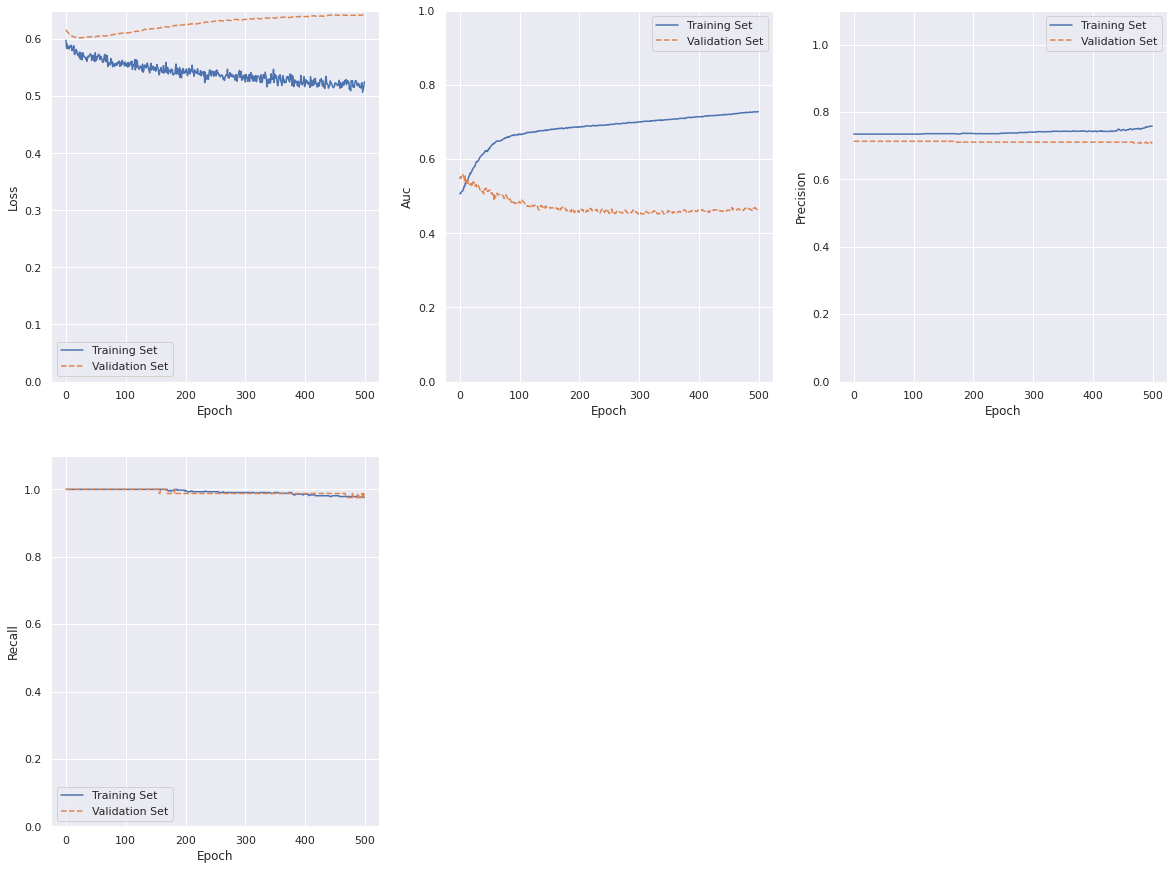

In [45]:
plt.figure(figsize=(20, 15))
plot_metrics(simple_nn_history)

### Draw an ROC curve.

Test AUC =  0.5982142857142857


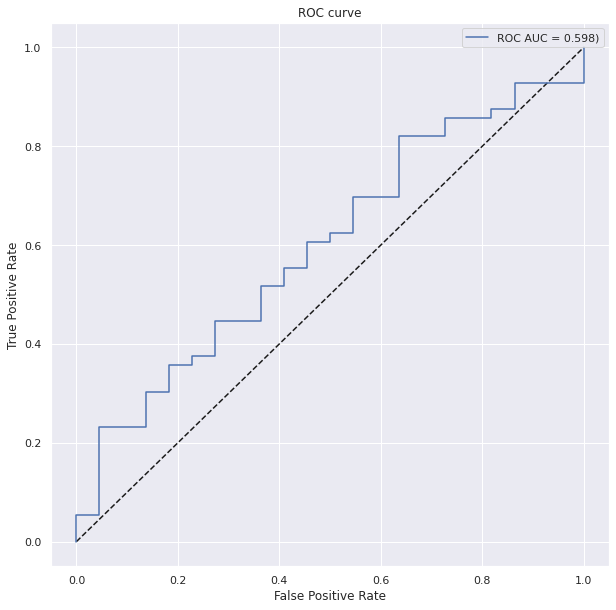

In [46]:
simple_nn_y_pred = simple_nn_model.predict(x_test).ravel()
simple_nn_fpr, simple_nn_tpr, thresholds_keras = roc_curve(y_test, simple_nn_y_pred)


simple_nn_auc = auc_value(simple_nn_fpr, simple_nn_tpr)
print("Test AUC = ", simple_nn_auc)

sns.set()
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(simple_nn_fpr, simple_nn_tpr, label='ROC AUC = {:.3f})'.format(simple_nn_auc))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')

### The dataset is imbalanced. So use resampling.

Text(0.5, 1.0, 'Win')

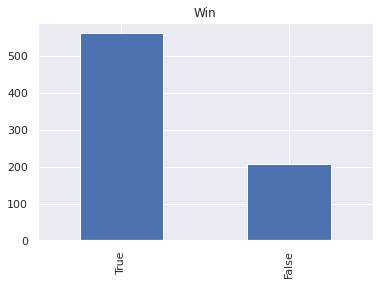

In [47]:
sns.set()
y.value_counts().plot.bar()
plt.title("Win")

In [0]:
EPOCHS = 500
BATCH_SIZE = 128

BUFFER_SIZE = 10000

def get_resampled_features():
  bool_train_labels = y_train != 0

  pos_features = x_train[bool_train_labels.values]
  neg_features = x_train[~bool_train_labels.values]

  pos_labels = y_train[bool_train_labels]
  neg_labels = y_train[~bool_train_labels]

  ids = np.arange(len(pos_features))
  choices = np.random.choice(ids, len(neg_features))

  res_pos_features = pos_features.iloc[choices]
  res_pos_labels = pos_labels.iloc[choices]

  resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
  resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

  order = np.arange(len(resampled_labels))
  np.random.shuffle(order)
  resampled_features = resampled_features[order]
  resampled_labels = resampled_labels[order]

  def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

  pos_ds = make_ds(pos_features, pos_labels)
  neg_ds = make_ds(neg_features, neg_labels)

  resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=class_weights)
  resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

  resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

  return resampled_ds, resampled_steps_per_epoch

In [49]:
resampled_ds, resampled_steps_per_epoch = get_resampled_features()

resampled_nn_model = make_model()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_nn_history = resampled_nn_model.fit(
                                          resampled_ds,
                                          epochs=EPOCHS,
                                          batch_size=BATCH_SIZE,
                                          steps_per_epoch=resampled_steps_per_epoch,
                                          validation_data=val_ds)

Epoch 1/500
3/3 [==============================] - 1s 237ms/step - loss: 0.7750 - auc: 0.4724 - precision: 0.7049 - recall: 0.2396 - val_loss: 0.7619 - val_auc: 0.5211 - val_precision: 1.0000 - val_recall: 0.0244
Epoch 2/500
3/3 [==============================] - 0s 7ms/step - loss: 0.7661 - auc: 0.5604 - precision: 0.7500 - recall: 0.0105 - val_loss: 0.7572 - val_auc: 0.5137 - val_precision: 1.0000 - val_recall: 0.0244
Epoch 3/500
3/3 [==============================] - 0s 7ms/step - loss: 0.7681 - auc: 0.4854 - precision: 0.5333 - recall: 0.0279 - val_loss: 0.7526 - val_auc: 0.5166 - val_precision: 1.0000 - val_recall: 0.0244
Epoch 4/500
3/3 [==============================] - 0s 8ms/step - loss: 0.7609 - auc: 0.4804 - precision: 0.7500 - recall: 0.0318 - val_loss: 0.7482 - val_auc: 0.5161 - val_precision: 0.6667 - val_recall: 0.0244
Epoch 5/500
3/3 [==============================] - 0s 7ms/step - loss: 0.7515 - auc: 0.4864 - precision: 0.6471 - recall: 0.0401 - val_loss: 0.7438 - val_

Plot metrics.

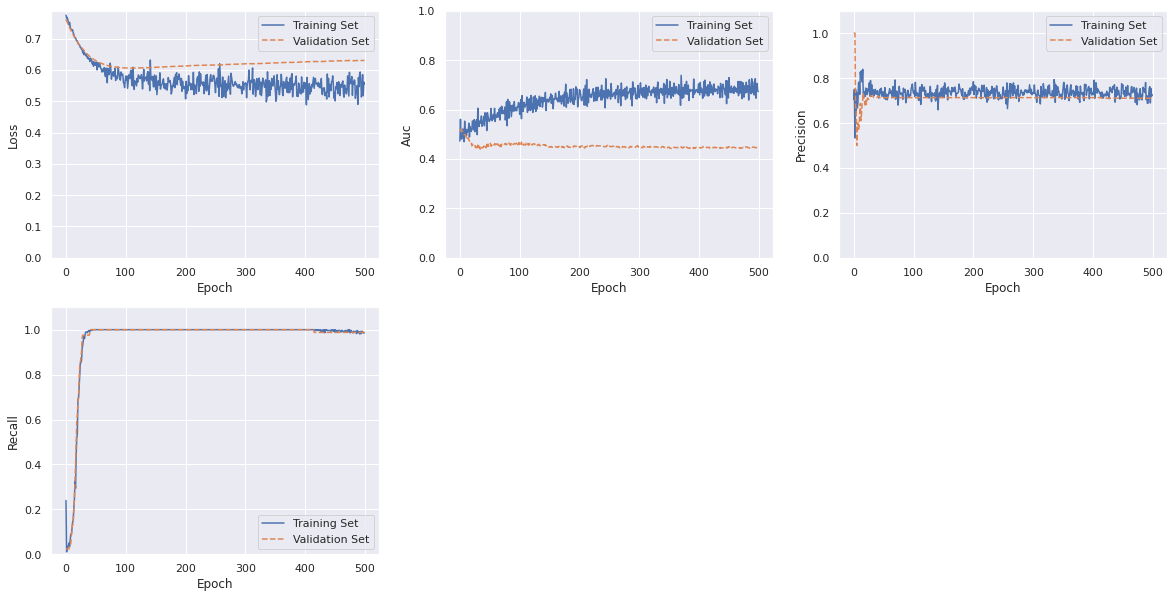

In [50]:
fig = plt.figure(figsize=(20, 10))
plot_metrics(resampled_nn_history)

Draw an ROC curve.

Test AUC =  0.5568181818181819


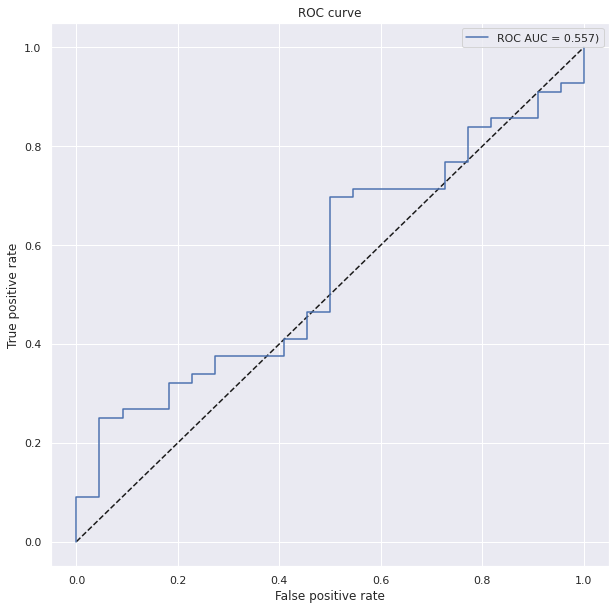

In [51]:
resampled_nn_y_pred = resampled_nn_model.predict(x_test).ravel()
resampled_nn_fpr, resampled_nn_tpr, thresholds_keras = roc_curve(y_test, resampled_nn_y_pred)

resampled_nn_auc = auc_value(resampled_nn_fpr, resampled_nn_tpr)
print("Test AUC = ", resampled_nn_auc)

sns.set()
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(resampled_nn_fpr, resampled_nn_tpr, label='ROC AUC = {:.3f})'.format(resampled_nn_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

Suggests very much that the result for earlier neural network was from overfitting. Verify that by using l2 regularization.

In [52]:
regularized_simple_nn_model = make_model(l2_penalty=0.1)
regularized_simple_nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 216       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [53]:
BATCH_SIZE = 128
EPOCHS = 500

regularized_simple_nn_history = regularized_simple_nn_model.fit(
                                                              x_train,
                                                              y_train,
                                                              batch_size=BATCH_SIZE,
                                                              epochs=EPOCHS,
                                                              validation_data=(x_val, y_val),
                                                              verbose=1)

Epoch 1/500
5/5 [==============================] - 0s 93ms/step - loss: 1.9051 - auc: 0.4767 - precision: 0.7304 - recall: 0.9980 - val_loss: 1.8994 - val_auc: 0.4324 - val_precision: 0.7130 - val_recall: 1.0000
Epoch 2/500
5/5 [==============================] - 0s 18ms/step - loss: 1.8538 - auc: 0.4889 - precision: 0.7344 - recall: 1.0000 - val_loss: 1.8535 - val_auc: 0.4340 - val_precision: 0.7130 - val_recall: 1.0000
Epoch 3/500
5/5 [==============================] - 0s 18ms/step - loss: 1.8129 - auc: 0.4886 - precision: 0.7344 - recall: 1.0000 - val_loss: 1.8088 - val_auc: 0.4322 - val_precision: 0.7130 - val_recall: 1.0000
Epoch 4/500
5/5 [==============================] - 0s 17ms/step - loss: 1.7647 - auc: 0.4884 - precision: 0.7344 - recall: 1.0000 - val_loss: 1.7656 - val_auc: 0.4340 - val_precision: 0.7130 - val_recall: 1.0000
Epoch 5/500
5/5 [==============================] - 0s 17ms/step - loss: 1.7227 - auc: 0.4900 - precision: 0.7344 - recall: 1.0000 - val_loss: 1.7236 - v

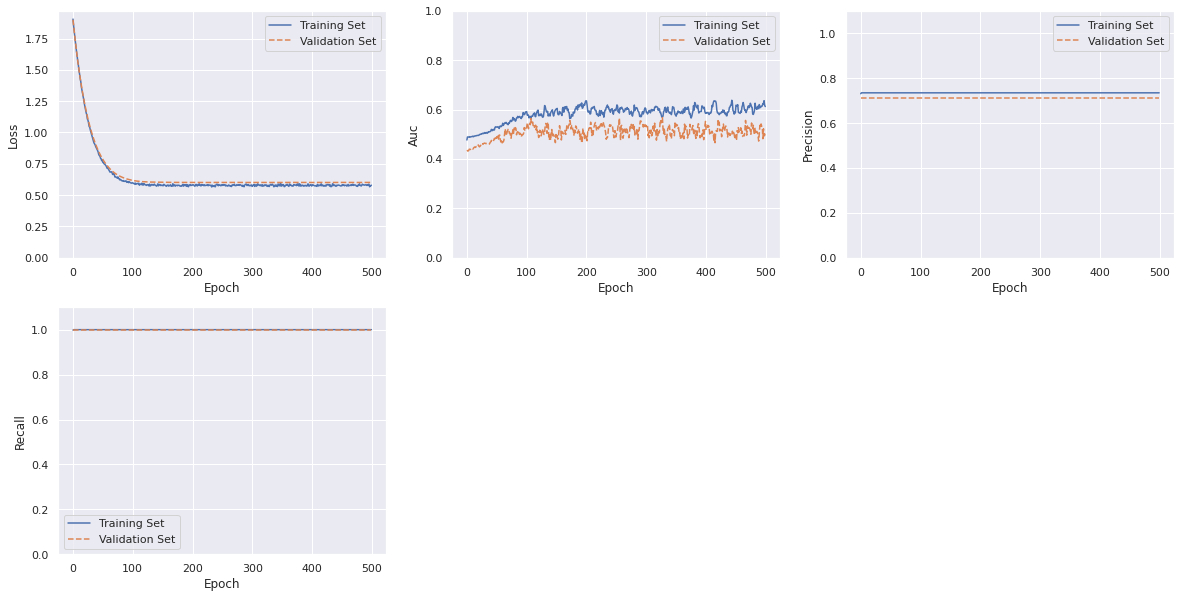

In [54]:
fig = plt.figure(figsize=(20, 10))
plot_metrics(regularized_simple_nn_history)

Test AUC =  0.5332792207792207


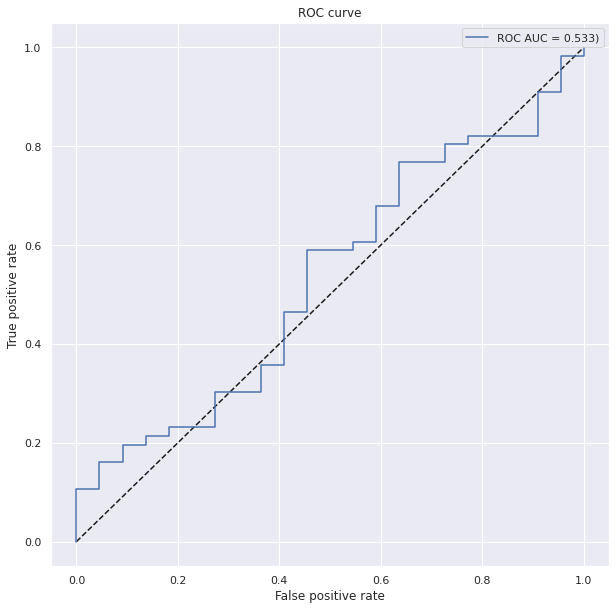

In [55]:
regularized_simple_nn_y_pred = regularized_simple_nn_model.predict(x_test).ravel()
regularized_simple_nn_fpr, regularized_simple_nn_tpr, thresholds_keras = roc_curve(y_test, regularized_simple_nn_y_pred)

regularized_simple_nn_auc = auc_value(regularized_simple_nn_fpr, regularized_simple_nn_tpr)
print("Test AUC = ", regularized_simple_nn_auc)

sns.set()
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(regularized_simple_nn_fpr, regularized_simple_nn_tpr, label='ROC AUC = {:.3f})'.format(regularized_simple_nn_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

#### Try resampled neural network with regularization.

In [0]:
reg_resampled_ds, reg_resampled_steps_per_epoch = get_resampled_features()
regularized_resampled_nn_model = make_model(l2_penalty=0.1)

In [57]:
BATCH_SIZE = 128
EPOCHS = 500

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

regularized_resampled_nn_history = regularized_resampled_nn_model.fit(
                                                              reg_resampled_ds,
                                                              epochs=EPOCHS,
                                                              batch_size=BATCH_SIZE,
                                                              steps_per_epoch=reg_resampled_steps_per_epoch,
                                                              validation_data=val_ds)

Epoch 1/500
3/3 [==============================] - 0s 132ms/step - loss: 1.8545 - auc: 0.5067 - precision: 0.7197 - recall: 0.4791 - val_loss: 1.8283 - val_auc: 0.5455 - val_precision: 0.7556 - val_recall: 0.4146
Epoch 2/500
3/3 [==============================] - 0s 7ms/step - loss: 1.8306 - auc: 0.4943 - precision: 0.7094 - recall: 0.2996 - val_loss: 1.8002 - val_auc: 0.5434 - val_precision: 0.7660 - val_recall: 0.4390
Epoch 3/500
3/3 [==============================] - 0s 6ms/step - loss: 1.8037 - auc: 0.4950 - precision: 0.7554 - recall: 0.3633 - val_loss: 1.7724 - val_auc: 0.5419 - val_precision: 0.7647 - val_recall: 0.4756
Epoch 4/500
3/3 [==============================] - 0s 7ms/step - loss: 1.7764 - auc: 0.4688 - precision: 0.6842 - recall: 0.3939 - val_loss: 1.7451 - val_auc: 0.5501 - val_precision: 0.7407 - val_recall: 0.4878
Epoch 5/500
3/3 [==============================] - 0s 7ms/step - loss: 1.7342 - auc: 0.5747 - precision: 0.8070 - recall: 0.4726 - val_loss: 1.7184 - val_

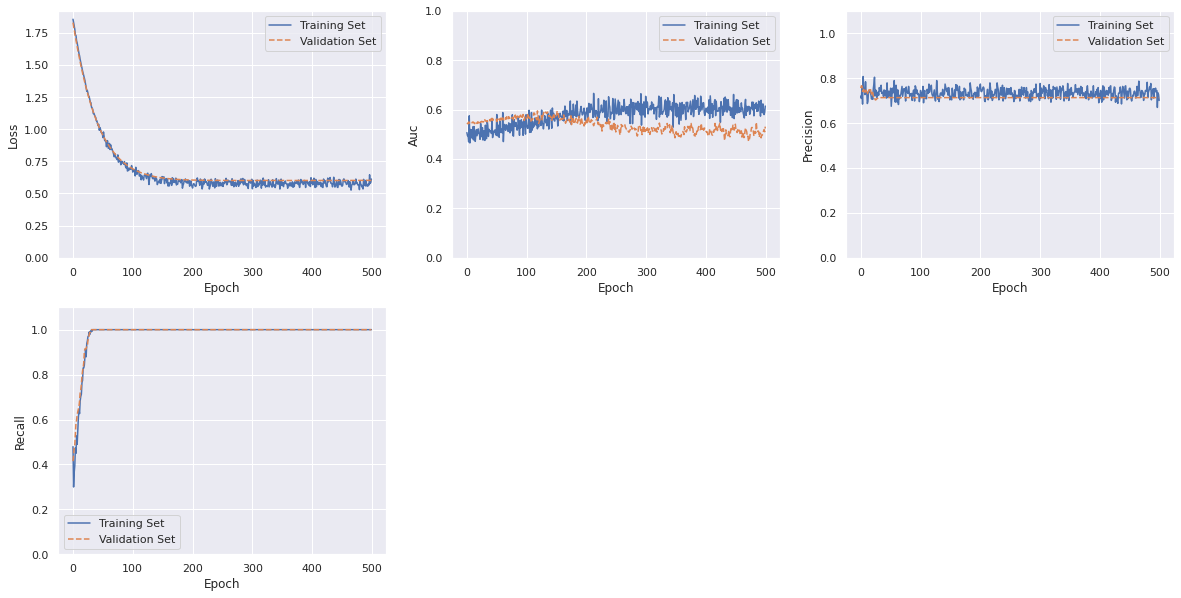

In [58]:
fig = plt.figure(figsize=(20, 10))
plot_metrics(regularized_resampled_nn_history)

Test AUC =  0.525974025974026


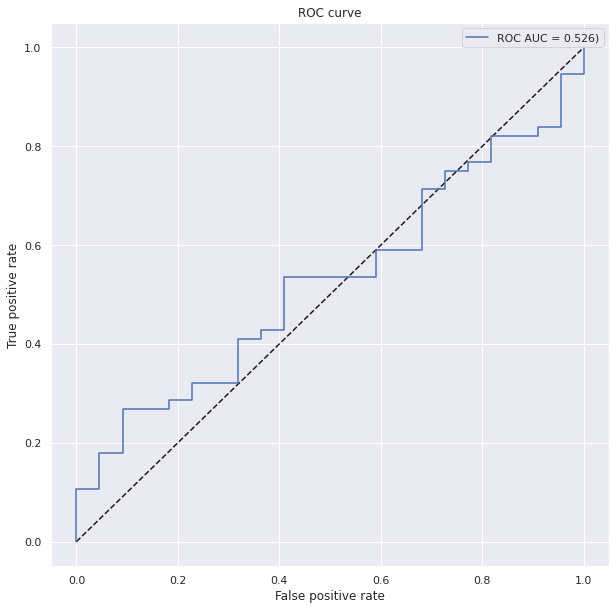

In [59]:
regularized_resampled_nn_y_pred = regularized_resampled_nn_model.predict(x_test).ravel()
regularized_resampled_nn_fpr, regularized_resampled_nn_tpr, thresholds_keras = roc_curve(y_test, regularized_resampled_nn_y_pred)
regularized_resampled_nn_auc = auc_value(regularized_resampled_nn_fpr, regularized_resampled_nn_tpr)

print("Test AUC = ", regularized_resampled_nn_auc)

sns.set()
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(regularized_resampled_nn_fpr, regularized_resampled_nn_tpr, label='ROC AUC = {:.3f})'.format(regularized_resampled_nn_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

So it seems that our neural networks were overfitting and when they are regularized, they perform no better than randomly guessing. This might be better with more data and is worth exploring.

It's a possiblity that performance in the practice games before a match affect the outcome of a match. So use a LSTM to explore that possibility.

### LSTM

In [0]:
catapult_df_practice_only = catapult_df_games[(~catapult_df_games['game'])]

all_features_median = {key:'median' for key in features_to_use}
all_features_median['start_timestamp'] = 'first'
all_features_median['end_timestamp'] = 'first'
all_features_median['Period Name'] = 'first'
all_features_median['Date'] = 'first'
all_features_median['win'] = 'first'

catapult_df_games_means = catapult_df_games_only.groupby('Period Name').agg(all_features_median).sort_values('start_timestamp')

catapult_df_practices_means = catapult_df_practice_only.groupby('Period Name').agg(all_features_median).sort_values('start_timestamp')

all_games_start_time = time.mktime(datetime.datetime.strptime("11/04/16 21:01:42", "%m/%d/%y %H:%M:%S").timetuple())

In [0]:
timesteps = 14

last_timestamp = all_games_start_time
lstm_features_to_use = features_to_use

x = []
y = []
for i, row in catapult_df_games_means.iterrows():
  # Find all practice games before this match but after the last match.
  # For the beginning of a new season, only look at practice games right before it.
  if row['Period Name'] == "Game-vs-North-Florida-November-11-2017":
    last_timestamp = catapult_df_practices_means.loc[catapult_df_practices_means['Period Name'] == "Team-Practice-25--November-4--2017"].iloc[0]['start_timestamp']

  practice_games_before_this_match = catapult_df_practices_means.loc[(catapult_df_practices_means['end_timestamp'] < row['start_timestamp']) & (catapult_df_practices_means['start_timestamp'] > last_timestamp)]
  last_timestamp = row['end_timestamp']

  features_before_current = practice_games_before_this_match[lstm_features_to_use].to_numpy()
  number_to_pad = timesteps - len(features_before_current)
  padded_features = np.pad(features_before_current, ((0, number_to_pad), (0, 0)), 'constant', constant_values=0).tolist()

  x.extend([a for a in padded_features])
  y.append(int(row['win']))
  
x = StandardScaler().fit_transform(np.array(x))
y = np.array(y)

x_for_lstm = x.reshape((len(x) // timesteps, timesteps, len(lstm_features_to_use) ))

In [0]:
train_ratio = 0.65
validation_ratio = 0.10
test_ratio = 0.25

x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(x_for_lstm, y, test_size=1 - train_ratio)
x_val_lstm, x_test_lstm, y_val_lstm, y_test_lstm = train_test_split(x_test_lstm, y_test_lstm, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [63]:
EPOCHS = 1000
BATCH_SIZE = 32


lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=0., input_shape=(timesteps, len(lstm_features_to_use))),
    tf.keras.layers.LSTM(4, input_shape=(timesteps, len(lstm_features_to_use)), kernel_regularizer=regularizers.l2(0.1)),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1))
])


lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

lstm_history = lstm_model.fit(
                x_train_lstm, 
                y_train_lstm, 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS, 
                verbose=1,
                validation_data=(x_val_lstm, y_val_lstm)
                )

Epoch 1/1000
2/2 [==============================] - 2s 902ms/step - loss: 2.8555 - auc: 0.5394 - precision: 0.6981 - recall: 0.9911 - val_loss: 2.8481 - val_auc: 0.9583 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 2/1000
2/2 [==============================] - 0s 24ms/step - loss: 2.8150 - auc: 0.5156 - precision: 0.6591 - recall: 0.9667 - val_loss: 2.8163 - val_auc: 0.7500 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/1000
2/2 [==============================] - 0s 24ms/step - loss: 2.7911 - auc: 0.4833 - precision: 0.6591 - recall: 0.9667 - val_loss: 2.7848 - val_auc: 0.7083 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/1000
2/2 [==============================] - 0s 27ms/step - loss: 2.7405 - auc: 0.5256 - precision: 0.6591 - recall: 0.9667 - val_loss: 2.7537 - val_auc: 0.7083 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/1000
2/2 [==============================] - 0s 24ms/step - loss: 2.7118 - auc: 0.5833 - precision: 0.6591 - recall: 0.9667 - val_loss: 2.72

Plot metrics.

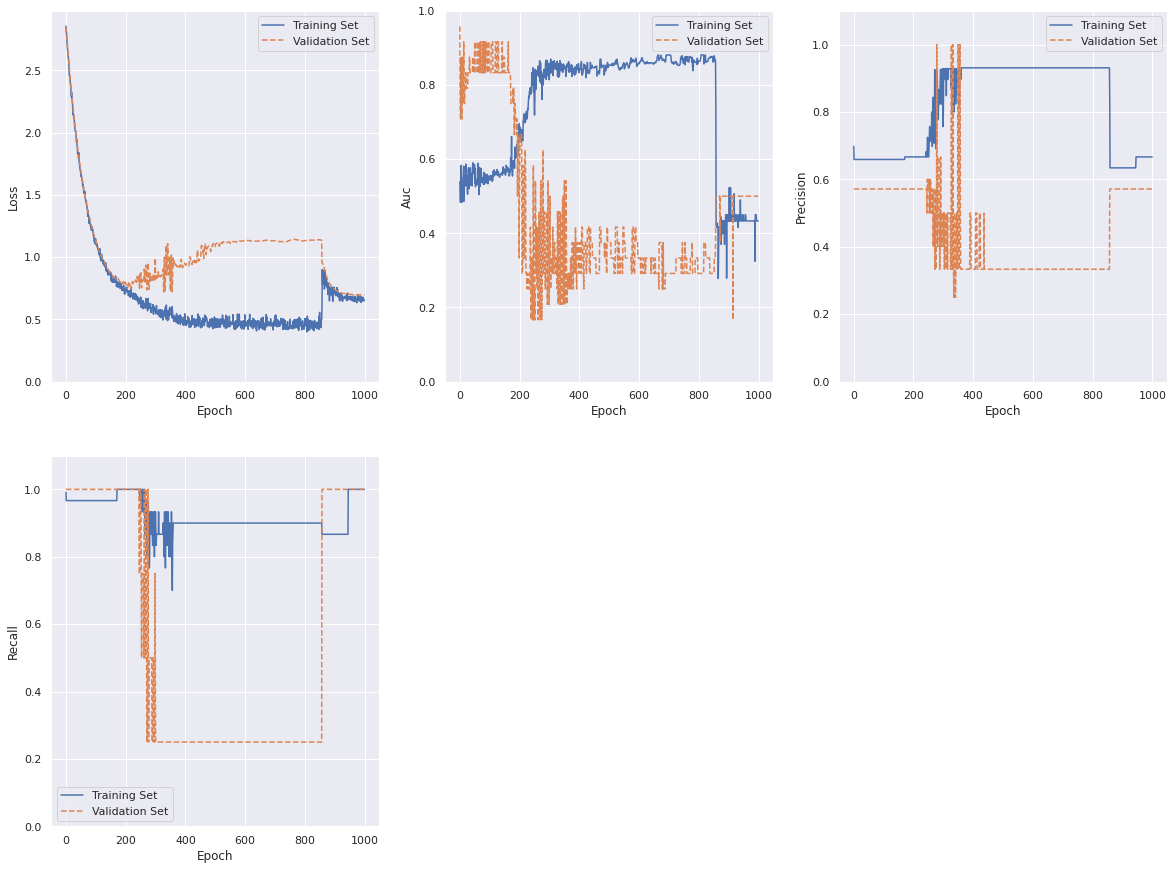

In [64]:
plt.figure(figsize=(20, 15))
plot_metrics(lstm_history)

Plot ROC curve and look at AUC.

Test AUC =  0.29411764705882354


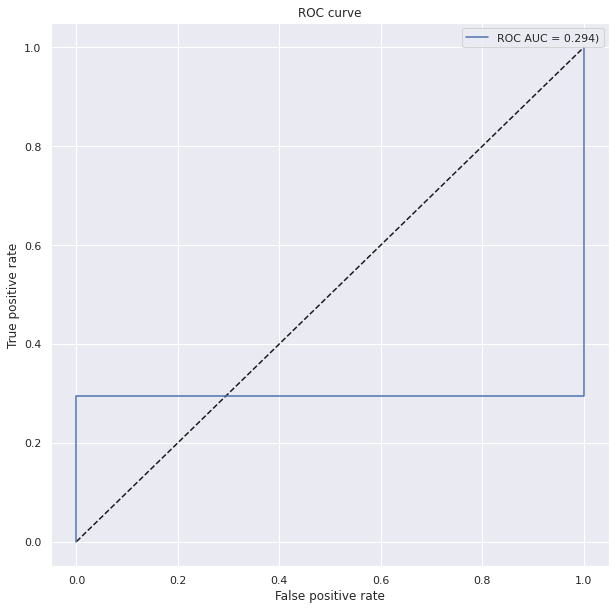

In [65]:
lstm_y_pred = lstm_model.predict(x_test_lstm).ravel()
lstm_fpr, lstm_tpr, thresholds_keras = roc_curve(y_test_lstm, lstm_y_pred)

lstm_auc = auc_value(lstm_fpr, lstm_tpr)
print("Test AUC = ", lstm_auc)

sns.set()
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lstm_fpr, lstm_tpr, label='ROC AUC = {:.3f})'.format(lstm_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

Like earlier, we don't seem to be doing much better than randomly guessing. This is very likely because we do not have a big enough sample size. For the LSTM, there were only 70 matches to fit with and even that was split into training, test, and validation. So while our LSTM didn't give promising results, the prospect of using LSTM to analyze past matches to predict future matches is promising and very exciting.

## Understanding the Relation between Player Load during Practice before games and the Game Result using Unsupervised Learning

Preparing Data for Unsupervised Learning

In [0]:
game_df = pd.read_csv('/content/ncaa-michigan-game-data.csv')
catapult_df = pd.read_csv("/content/michigan-catapult-data.csv")
season_df = pd.read_csv("/content/ncaa-michigan-season-data.csv")

In [0]:
#Dropping rows where there is no Player Load data
indexes_0=catapult_df[catapult_df['Total Player Load'].astype(int)==0].index
catapult_df.drop(indexes_0,inplace=True)

In [0]:
#Modifying datetime format for easy manipulation
catapult_df['scheduled_date'] = pd.to_datetime(catapult_df['Date'], format='%m/%d/%Y').apply(convert_date)

datetimes_str=pd.to_datetime(catapult_df['scheduled_date'])
catapult_df['dtime_format']=datetimes_str
catapult_df=catapult_df.sort_values(by='dtime_format');

datetimes_games_df=pd.to_datetime(game_df['scheduled_date'])
game_df['dtime_format']=datetimes_games_df
game_df=game_df.sort_values(by='dtime_format');

In [0]:
#Adding columns for total duration for which the Players remain in a particular load band

def convert_duration_to_seconds(time_form):
  dtime=datetime.datetime.strptime(time_form,'%H:%M:%S')
  total_seconds=dtime.hour*3600+dtime.minute*60+dtime.second
  return total_seconds

catapult_df['Total Instructional_seconds']=catapult_df['Total Instructional'].apply(convert_duration_to_seconds)
catapult_df['Low Intensity Movement_seconds']=catapult_df['Low Intensity Movement'].apply(convert_duration_to_seconds)
catapult_df['Player Load Band 3 Total Duration_seconds']=catapult_df['Player Load Band 3 Total Duration'].apply(convert_duration_to_seconds)
catapult_df['Player Load Band 4 Total Duration_seconds']=catapult_df['Player Load Band 4 Total Duration'].apply(convert_duration_to_seconds)
catapult_df['Total Duration_seconds']=catapult_df['Total Duration'].apply(convert_duration_to_seconds)


Plot of Total Player Load for the Practice Data showing values for different load bands. There seems to be an error in this dataset - Band 4 Loads are lower than the Band 3 (High Intenstity Movement) Loads. We tried to contact the MIDAS team regarding this but didn't get any reply, so we avoided interchanging columns as of yet, because we are not sure if the 'duration' columns need to be interchanged as well. This might change how we interpret the results though.

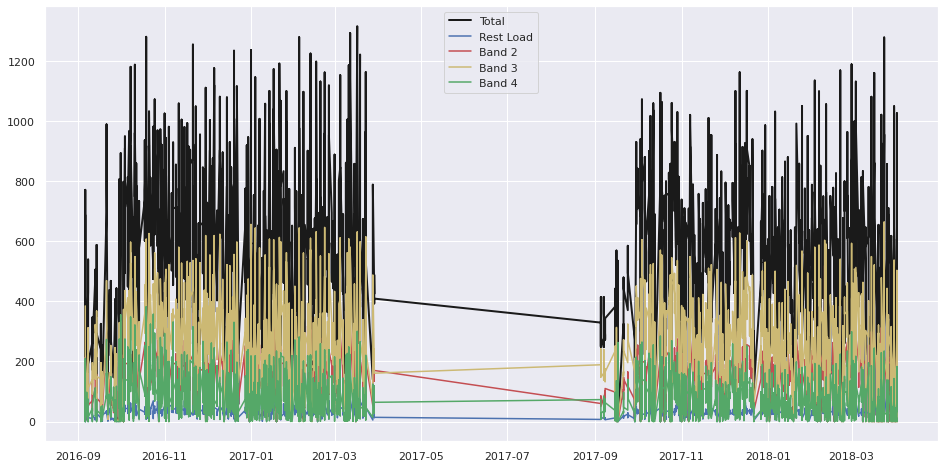

In [70]:
#Checking the relation between Total player load and each load band
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
ax.plot(catapult_df['dtime_format'],catapult_df['Total Player Load'],c='k', lw=2,label='Total')
ax.plot(catapult_df['dtime_format'],catapult_df['Rest Load'],c='b',label='Rest Load')
ax.plot(catapult_df['dtime_format'],catapult_df['Player Load Band 2 Total Player Load'],c='r',label='Band 2')
ax.plot(catapult_df['dtime_format'],catapult_df['High Intensity Movement'],c='y',label='Band 3')
ax.plot(catapult_df['dtime_format'],catapult_df['Player Load Band 4 Total Player Load'],c='g',label='Band 4')
ax.legend(loc='best')

In [0]:
unique_players=catapult_df['Player ID'].unique()

#Adding columns which describe how the load of each player compares to their personal mean load values.


In [0]:

grp_players=catapult_df.groupby(by='Player ID')
catapult_df_add=pd.DataFrame()

for play in unique_players:
  df_select=catapult_df.loc[grp_players.groups[play]]
  df_select['Rest Load_above_norm']=df_select['Rest Load']-df_select['Rest Load'].mean()
  df_select['Band 2_above_norm']=df_select['Player Load Band 2 Total Player Load']-df_select['Player Load Band 2 Total Player Load'].mean()
  df_select['High Intensity_above_norm']=df_select['High Intensity Movement']-df_select['High Intensity Movement'].mean()
  df_select['Band 4_above_norm']=df_select['Player Load Band 4 Total Player Load']-df_select['Player Load Band 4 Total Player Load'].mean()

  catapult_df_add=pd.concat((catapult_df_add,df_select),axis=0)
 
catapult_df_add=catapult_df_add.sort_values(by='dtime_format');

In [0]:
#Dividing the catapult dataframe by activity type

catapult_df_add['game'] = catapult_df_add['Period Name'].str.contains("Game")
catapult_df_add['practice'] = catapult_df_add['Period Name'].str.contains("Practice")
catapult_df_add['activity'] = catapult_df_add['Period Name'].str.contains("Activity")

catapult_df_games_usup=catapult_df_add[catapult_df_add['game']]
catapult_df_practice=catapult_df_add[catapult_df_add['practice']]
catapult_df_activity=catapult_df_add[catapult_df_add['activity']]
catapult_df_more_practice=catapult_df_add[catapult_df_add['Period Name'].str.contains("Open-Gym|Conditioning|Warm|Voluntary|Extra|Walk|practice|Individual|PRactice")]
catapult_df_total_practice=pd.concat((catapult_df_practice,catapult_df_activity,catapult_df_more_practice), axis=0)

In [0]:
#Sorting the dataframes
catapult_df_total_practice=catapult_df_total_practice.sort_values(by='dtime_format');
catapult_df_games_usup=catapult_df_games_usup.sort_values(by='dtime_format');

Time Series of Player Loads during Games vs. Practice Sessions. Clearly, the Player Loads are much higher during the Games as compared to practices. Suprisingly, the Player Loads are lower in the 2018 season when the Team performed much better.

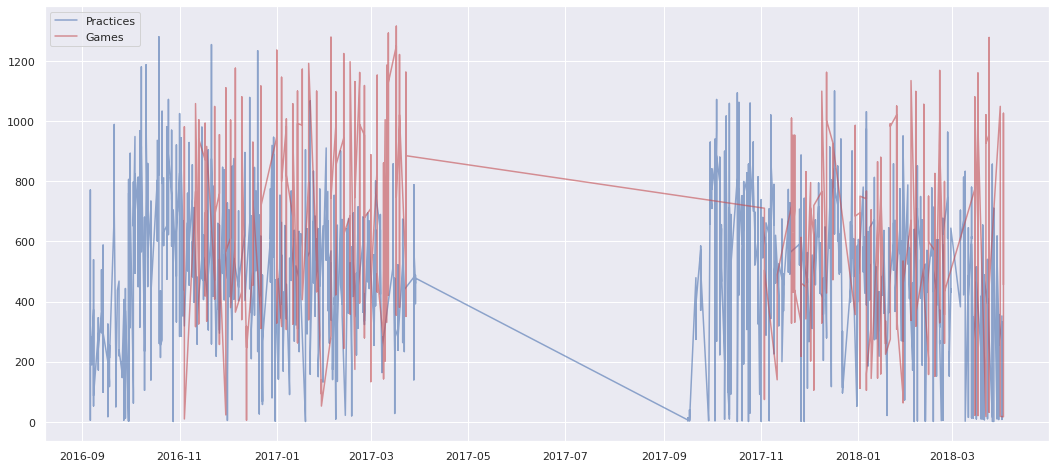

In [75]:
sns.set()
fig=plt.figure(figsize=(18,8))
ax=fig.add_subplot(111)
ax.plot(catapult_df_total_practice['dtime_format'],catapult_df_total_practice['Total Player Load'], c='b', alpha=0.6,label='Practices')
ax.plot(catapult_df_games_usup['dtime_format'],catapult_df_games_usup['Total Player Load'],c='r',alpha=0.6,label='Games')
ax.legend(loc='best')

## Merging the catapult Practice data and the Game data together

In [0]:
def merge_games_df_with_practice(df,game_df,n_days=None):
  modified_df=pd.DataFrame()
  practice_game_features=pd.DataFrame()
  for i,dd in enumerate(game_df['dtime_format']):
    if i==0:
      if n_days!=None:
        small_date=df[(df['dtime_format']<=dd) &\
                                          ((dd-df['dtime_format'])<datetime.timedelta(days=n_days))]
      else:
        small_date=df[(df['dtime_format']<=dd)]
    else:
      prev_date=game_df['dtime_format'].values[i-1]
      if n_days!=None:
        small_date=df[(df['dtime_format']<=dd) & (df['dtime_format']>prev_date) &\
                                          ((dd-df['dtime_format'])<datetime.timedelta(days=n_days))]
      else:
        small_date=df[(df['dtime_format']<=dd) & (df['dtime_format']>prev_date)]
    #print(small_date.shape, dd)
    extra_game_rows=len(small_date)
    if extra_game_rows!=0:
      add_df=pd.DataFrame([game_df.iloc[i]]*extra_game_rows)
      practice_game_features=pd.concat((practice_game_features,add_df),axis=0)
      modified_df=pd.concat((modified_df,small_date),axis=0)
  return practice_game_features,modified_df 

In [0]:
catapult_df_total_practice_game_features,catapult_cut_merge=merge_games_df_with_practice(catapult_df_total_practice,game_df)

col=catapult_df_total_practice_game_features.columns
col=col.delete(-1) #Deleting columns with duplicate names
col=col.delete(2) 
drop=catapult_df_total_practice_game_features[col]
drop=drop.reset_index(drop=True)
catapult_cut_merge=catapult_cut_merge.reset_index(drop=True)

merged_game_catapult_practice=pd.concat((catapult_cut_merge,drop),axis=1)

#TODO : Merge catapult games df

2702 566


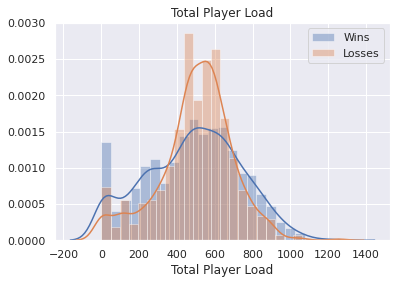

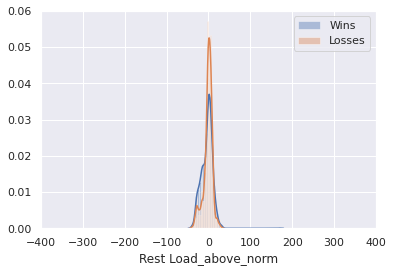

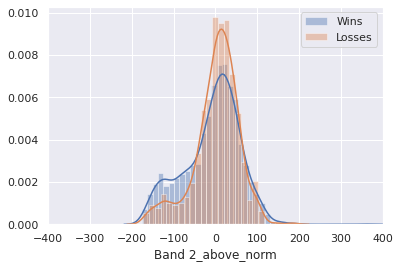

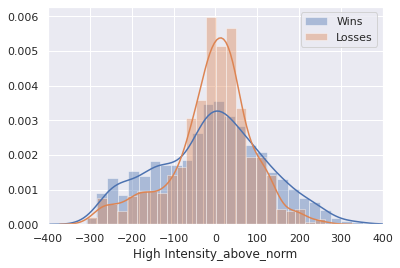

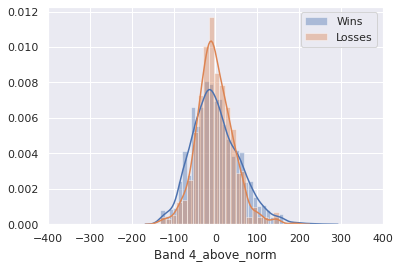

In [78]:
#Raw separation by wins and losses
cols_above_mean_effort=merged_game_catapult_practice.columns[merged_game_catapult_practice.columns.str.contains('above')]
wins=merged_game_catapult_practice[merged_game_catapult_practice['win']==True]
losses=merged_game_catapult_practice[merged_game_catapult_practice['win']==False]
print(len(wins),len(losses))
fig=plt.figure()
ax=fig.add_subplot(111)
sns.distplot(wins['Total Player Load'],label='Wins')
sns.distplot(losses['Total Player Load'],label='Losses')
ax.set_title('Total Player Load')
ax.legend(loc='best')

for cols in cols_above_mean_effort:
  fig=plt.figure()
  ax=fig.add_subplot(111)
  sns.distplot(wins[cols],label='Wins')
  sns.distplot(losses[cols],label='Losses')
  ax.set_xlim(-400,400)
  ax.legend(loc='best')

Text(0.5, 1.0, 'Wins')

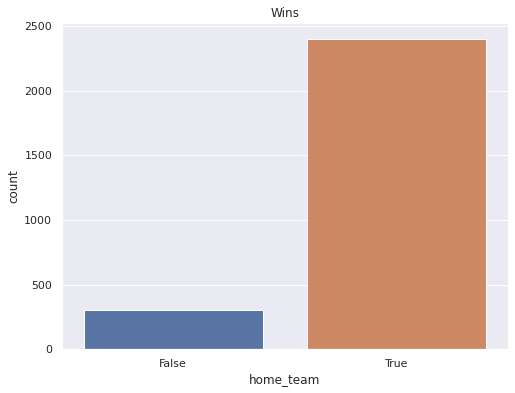

In [79]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
sns.countplot(wins['home_team'])
ax.set_title('Wins')

(-700.0, 700.0)

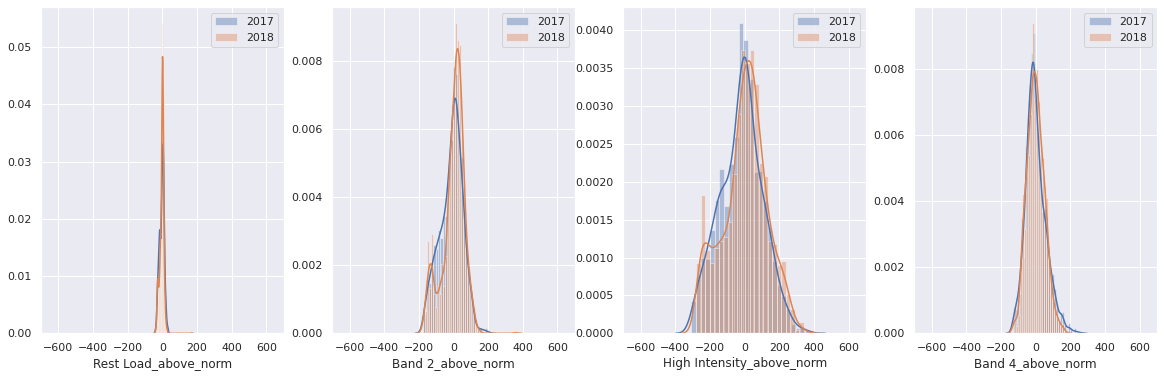

In [80]:
#Comparing the Player Loads for two seasons
merged_game_catapult_practice_2017 = merged_game_catapult_practice.loc[merged_game_catapult_practice['season']==2017]
merged_game_catapult_practice_2018= merged_game_catapult_practice.loc[merged_game_catapult_practice['season']==2018]

fig=plt.figure(figsize=(20,6))
ax=fig.add_subplot(141)
sns.distplot(merged_game_catapult_practice_2017['Rest Load_above_norm'],label='2017')
sns.distplot(merged_game_catapult_practice_2018['Rest Load_above_norm'],label='2018')
ax.legend(loc='best')
ax.set_xlim(-700,700)

ax=fig.add_subplot(142)
sns.distplot(merged_game_catapult_practice_2017['Band 2_above_norm'],label='2017')
sns.distplot(merged_game_catapult_practice_2018['Band 2_above_norm'],label='2018')
ax.legend(loc='best')
ax.set_xlim(-700,700)

ax=fig.add_subplot(143)
sns.distplot(merged_game_catapult_practice_2017['High Intensity_above_norm'],label='2017')
sns.distplot(merged_game_catapult_practice_2018['High Intensity_above_norm'],label='2018')
ax.legend(loc='best')
ax.set_xlim(-700,700)

ax=fig.add_subplot(144)
sns.distplot(merged_game_catapult_practice_2017['Band 4_above_norm'],label='2017')
sns.distplot(merged_game_catapult_practice_2018['Band 4_above_norm'],label='2018')
ax.legend(loc='best')
ax.set_xlim(-700,700)

In [0]:
#Features that we will be using for clustering data
'''
clustering_features=[
       'Player ID','IMA Accel Low','IMA Accel Medium', 'IMA Accel High', 
       'IMA Decel Low','IMA Decel Medium', 'IMA Decel High', 
       'IMA CoD Left Low','IMA CoD Left Medium', 'IMA CoD Left High', 
       'IMA CoD Right Low','IMA CoD Right Medium', 'IMA CoD Right High', 
       'IMA Jump Count Low Band', 'IMA Jump Count Med Band', 'IMA Jump Count High Band', 
       'Rest Load', 'Player Load Band 2 Total Player Load', 
       'High Intensity Movement', 'Player Load Band 4 Total Player Load', 
       'Total Instructional_seconds', 'Low Intensity Movement_seconds', 
       'Player Load Band 3 Total Duration_seconds', 'Player Load Band 4 Total Duration_seconds']
'''
clustering_features=['Total IMA','Total Jumps','Rest Load', 'Player Load Band 2 Total Player Load', 
       'High Intensity Movement', 'Player Load Band 4 Total Player Load', 
       'Total Instructional_seconds', 'Low Intensity Movement_seconds', 
       'Player Load Band 3 Total Duration_seconds', 'Player Load Band 4 Total Duration_seconds']

merged_game_catapult_practice_clusters=merged_game_catapult_practice[clustering_features]
#merged_game_catapult_practice_clusters.shape
#(merged_game_catapult_practice_clusters==0).sum()

In [0]:
# scaling all the Features
scaler=MinMaxScaler()
merged_game_catapult_practice_clusters_scaled = pd.DataFrame(scaler.fit_transform(merged_game_catapult_practice_clusters.values) \
                                                          , columns=merged_game_catapult_practice_clusters.columns, index=merged_game_catapult_practice_clusters.index)

Using TSNE to reduce the dimensions of our data. It should be noted that everytime we run this cell, the scatterplot might look different. However, it does not change our results.

In [83]:
x_embedded=TSNE(n_components=2,perplexity=50, learning_rate=200.0, n_iter=5000).fit_transform(merged_game_catapult_practice_clusters_scaled)
x_embedded.shape

(3268, 2)

Text(0.5, 1.0, 'TSNE reduced embedding')

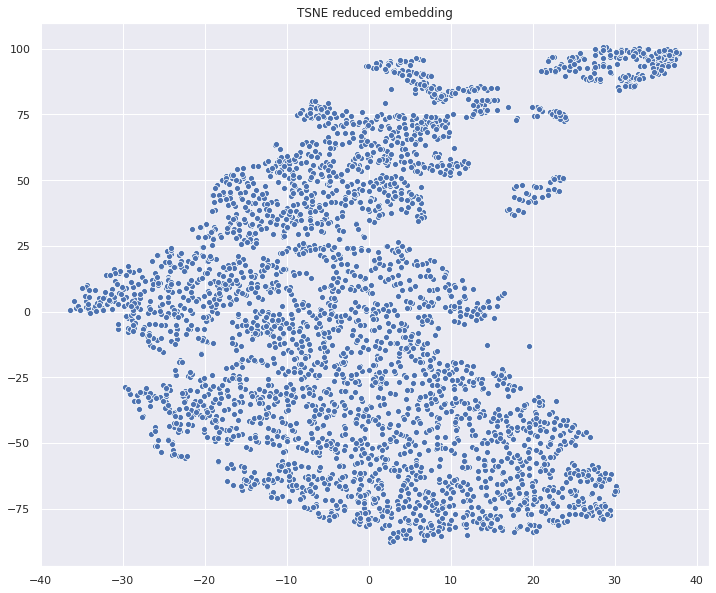

In [84]:
fig=plt.figure(figsize=(12,10))
ax=fig.add_subplot(111)
sns.scatterplot(x_embedded[:,0],x_embedded[:,1])
ax.set_title('TSNE reduced embedding')

Using K-Means to cluster and figuring out the appropriate amount of clusters

In [0]:
#Finding the optimal number of cluters for Kmeans
number_of_clusters=np.arange(2,13,1)
wss=[]
ss=[]
for i in number_of_clusters:
  x_kmeans=KMeans(n_clusters=i,random_state=1).fit(x_embedded)
  sil_coeff = silhouette_score(x_embedded, x_kmeans.labels_, metric='euclidean')
  ss.append(sil_coeff) #Calculating silhouette score
  wss.append(x_kmeans.inertia_) #Calculating the intra-cluster distances

#Gap statistic
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')
n_clusters = optimalK(x_embedded,cluster_array=np.arange(2, 13,1))

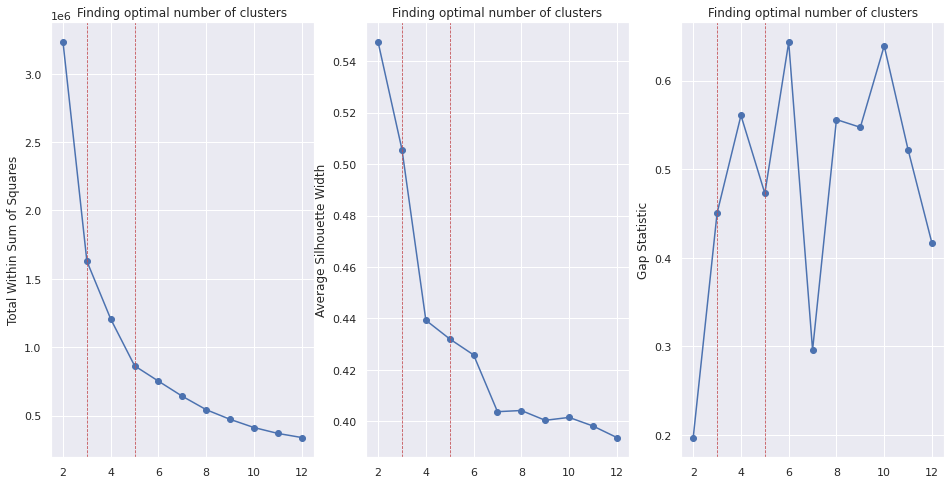

In [86]:
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,3,1)
ax.scatter(number_of_clusters,wss)
ax.plot(number_of_clusters,wss)
ax.set_ylabel('Total Within Sum of Squares')
ax.set_title('Finding optimal number of clusters')
ax.axvline(x=3,c='r',ls='--',lw=0.8)
ax.axvline(x=5,c='r',ls='--',lw=0.8)

ax=fig.add_subplot(1,3,2)
ax.scatter(number_of_clusters,ss)
ax.plot(number_of_clusters,ss)
ax.set_ylabel('Average Silhouette Width')
ax.set_title('Finding optimal number of clusters')
ax.axvline(x=3,c='r',ls='--',lw=0.8)
ax.axvline(x=5,c='r',ls='--',lw=0.8)

ax=fig.add_subplot(1,3,3)
ax.scatter(optimalK.gap_df['n_clusters'],optimalK.gap_df['gap_value'])
ax.plot(optimalK.gap_df['n_clusters'],optimalK.gap_df['gap_value'])
ax.set_ylabel('Gap Statistic')
ax.set_title('Finding optimal number of clusters')
ax.axvline(x=3,c='r',ls='--',lw=0.8)
ax.axvline(x=5,c='r',ls='--',lw=0.8)


Looking at the plots above, it seems 3 or 5 clusters should give us decent results. We ended up choosing 3 clusters because they were easy to handle and base our conclusions upon. 

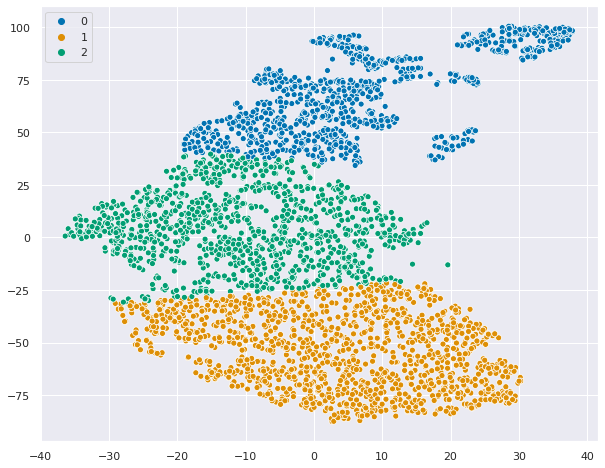

In [87]:
x_kmeans_3 = KMeans(n_clusters=3,random_state=1).fit(x_embedded)
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)
sns.scatterplot(x_embedded[:,0],x_embedded[:,1],x_kmeans_3.labels_,legend="full",palette="colorblind")

In [88]:
merged_game_catapult_practice_clusters['clusters']=x_kmeans_3.labels_
merged_game_catapult_practice['clusters']=x_kmeans_3.labels_
cluster_0=merged_game_catapult_practice_clusters[merged_game_catapult_practice_clusters['clusters']==0] 
cluster_1=merged_game_catapult_practice_clusters[merged_game_catapult_practice_clusters['clusters']==1]
cluster_2=merged_game_catapult_practice_clusters[merged_game_catapult_practice_clusters['clusters']==2]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Plotting different features for different clusters. We can see that the separation between clusters is much more for some feature than the others.

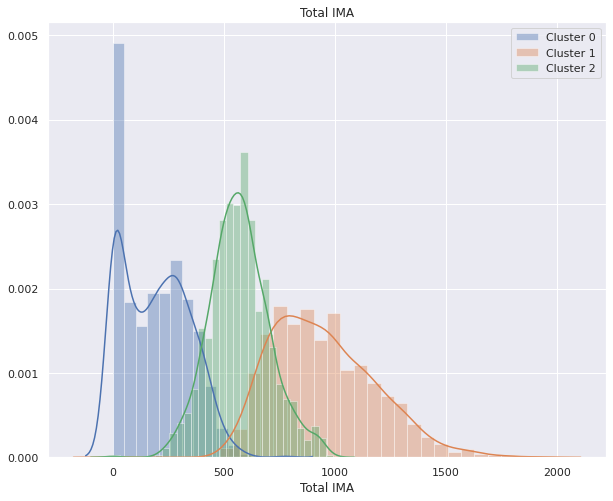

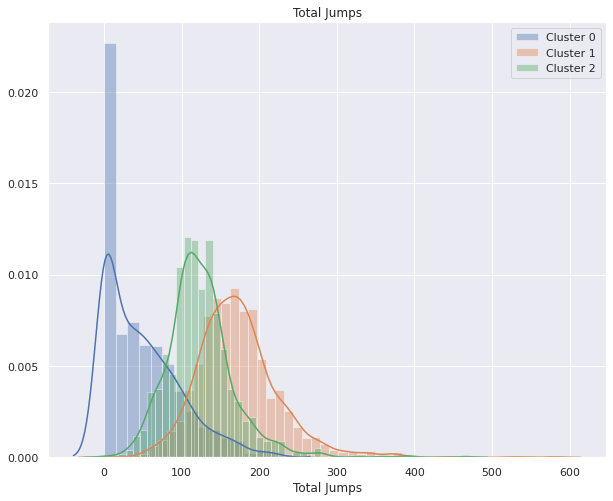

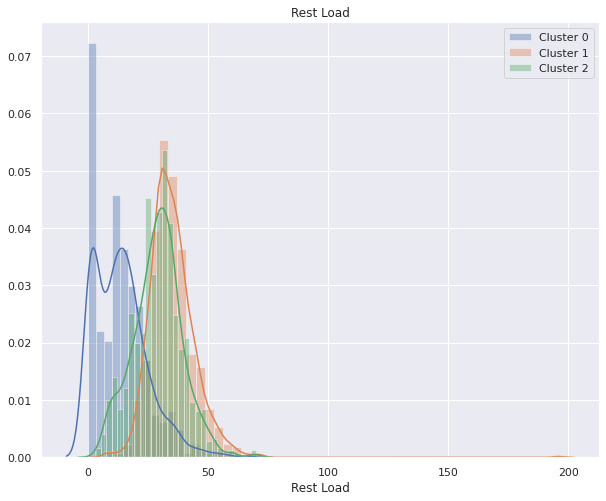

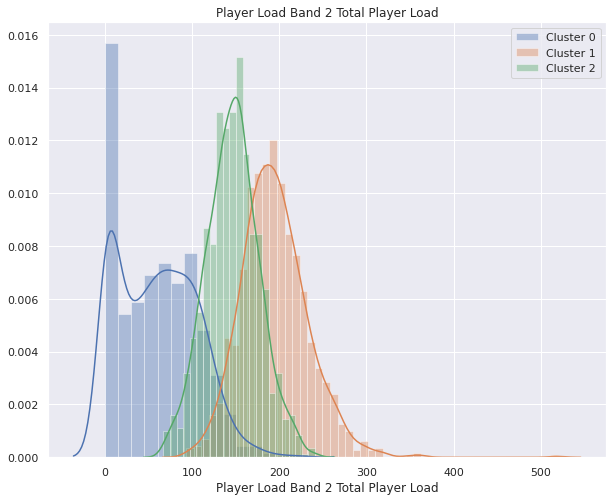

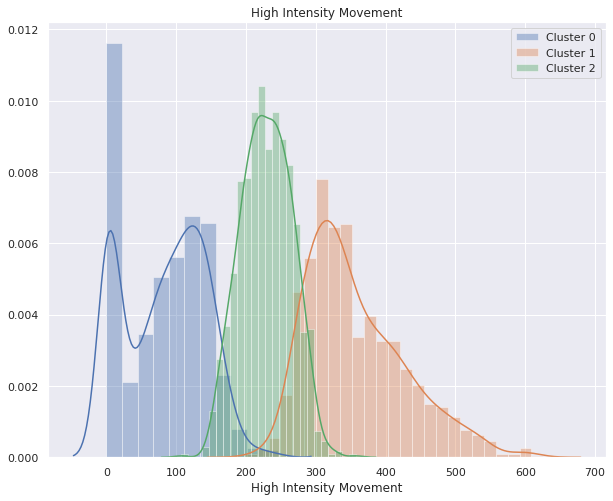

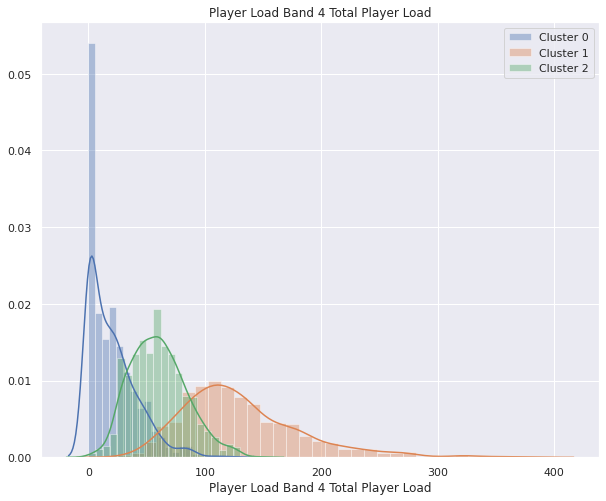

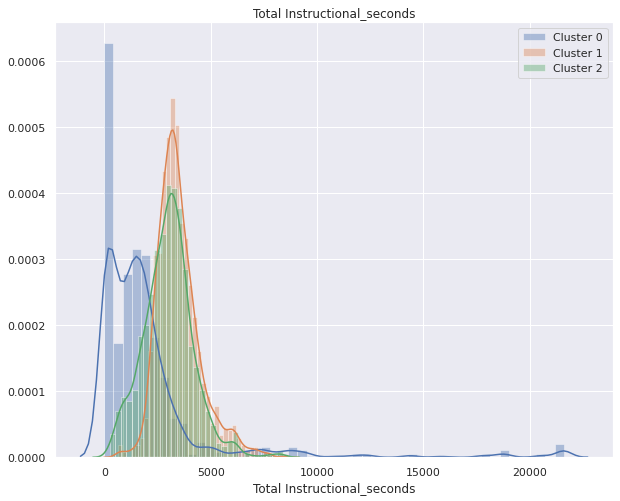

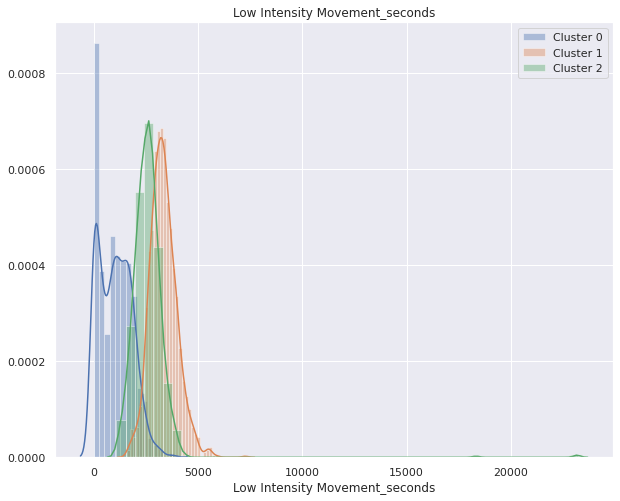

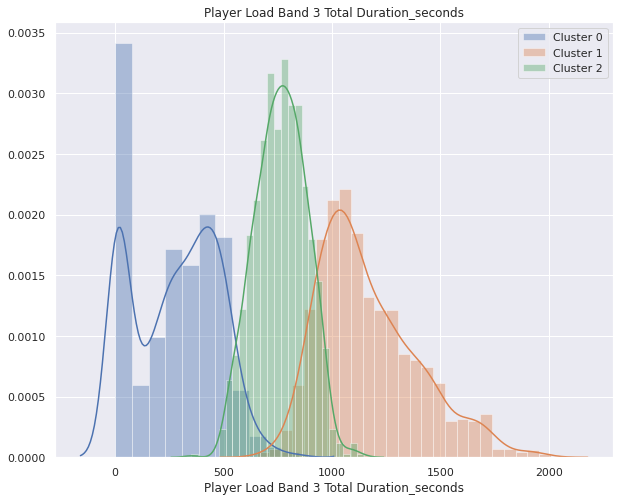

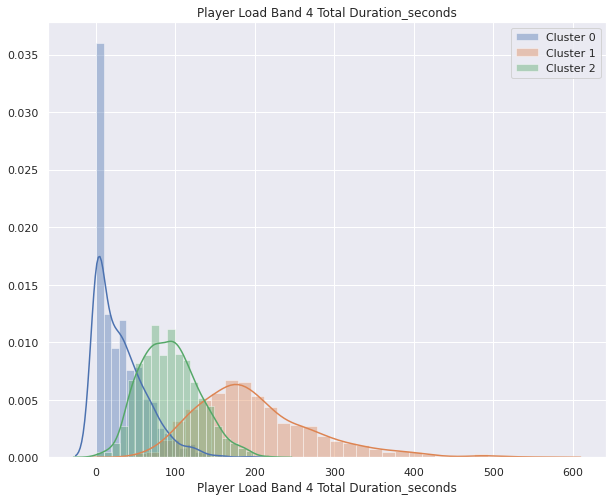

In [89]:
for i,feat in enumerate(merged_game_catapult_practice_clusters.columns[:-1]):
  fig=plt.figure(figsize=(10,8))
  ax=fig.add_subplot(111)
  sns.distplot(cluster_0[feat],label='Cluster 0')
  sns.distplot(cluster_1[feat],label='Cluster 1')
  sns.distplot(cluster_2[feat],label='Cluster 2')
  ax.legend(loc='best')
  ax.set_title(feat)

In [0]:
cluster_0_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==0]
cluster_1_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==1]
cluster_2_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==2]

Plotting Total Player Load for each of the cluster

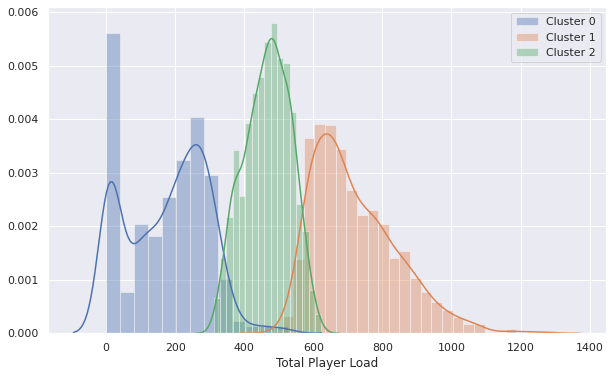

In [91]:
merged_game_catapult_practice['Total Player Load']
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
sns.distplot(cluster_0_full['Total Player Load'],label='Cluster 0')
sns.distplot(cluster_1_full['Total Player Load'],label='Cluster 1')
sns.distplot(cluster_2_full['Total Player Load'],label='Cluster 2')
ax.legend(loc='best')

Wins percentage for each of the clusters. On comparing with the plots above, this tells us that the cluster with higher player load also has higher percentage of wins, and vice-versa

In [92]:
wins_cluster_0=cluster_0_full['win']
wins_cluster_1=cluster_1_full['win']
wins_cluster_2=cluster_2_full['win']

cluster_0_counts=wins_cluster_0[wins_cluster_0==True].count()
cluster_1_counts=wins_cluster_1[wins_cluster_1==True].count()
cluster_2_counts=wins_cluster_2[wins_cluster_2==True].count()
total_wins=cluster_0_counts+cluster_1_counts+cluster_2_counts#+cluster_3_counts

print('Total win percentage : {} '.format(100*total_wins/len(merged_game_catapult_practice)))

print('Cluster 0 has {}% of the total wins'.format(100*cluster_0_counts/total_wins))
print('Cluster 1 has {}% of the total wins'.format(100*cluster_1_counts/total_wins))
print('Cluster 2 has {}% of the total wins'.format(100*cluster_2_counts/total_wins))

Total win percentage : 82.68053855569156 
Cluster 0 has 29.45965951147298% of the total wins
Cluster 1 has 39.74833456698742% of the total wins
Cluster 2 has 30.7920059215396% of the total wins


Plotting the Player Load above their mean values for different clusters. We can see that for the clusters with higher percentage of wins, players perform higher than their personal mean loads, and vice-versa.

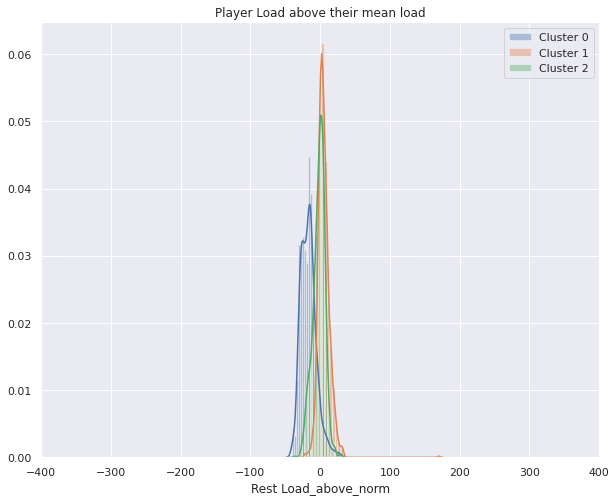

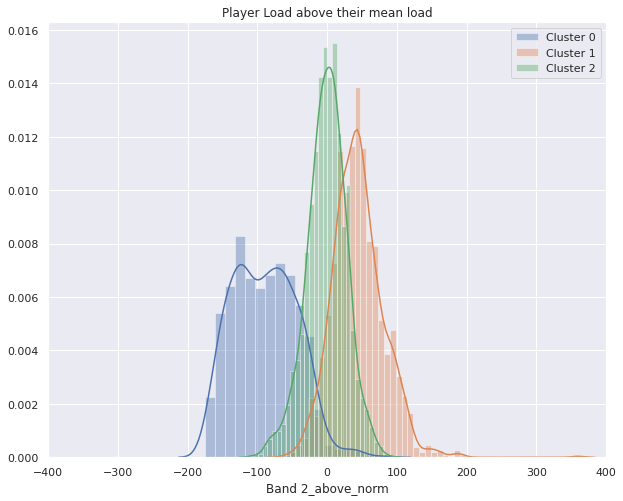

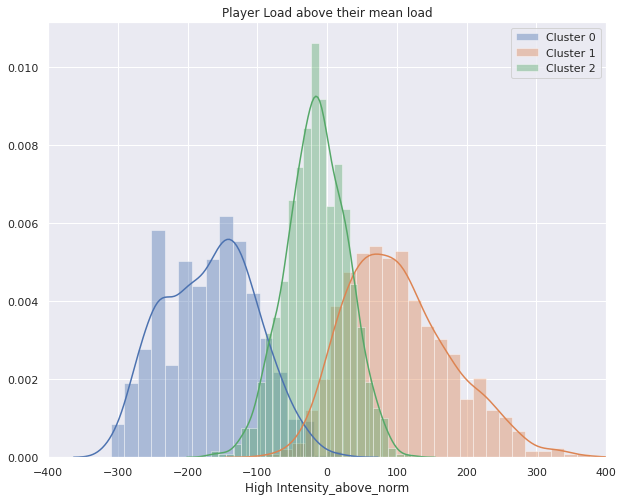

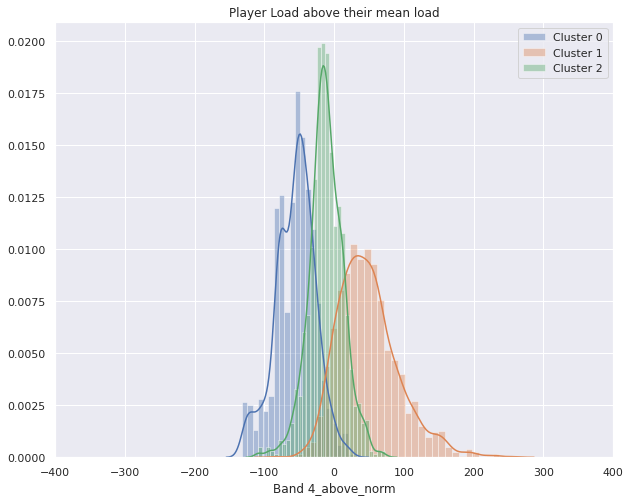

In [93]:
for cols in cols_above_mean_effort:
  fig=plt.figure(figsize=(10,8))
  ax=fig.add_subplot(111)
  sns.distplot(cluster_0_full[cols],label='Cluster 0')
  sns.distplot(cluster_1_full[cols],label='Cluster 1')
  sns.distplot(cluster_2_full[cols],label='Cluster 2')
  ax.set_title('Player Load above their mean load')
  ax.set_xlim(-400,400)
  ax.legend(loc='best')

# Repeating above methodology for practice sessions 2/3 days before a game

In [0]:
#Change the parameter in this call to change the number of days
catapult_df_total_practice_game_features,catapult_cut_merge=merge_games_df_with_practice(catapult_df_total_practice,game_df,2)

col=catapult_df_total_practice_game_features.columns
col=col.delete(-1) #Deleting columns with duplicate names
col=col.delete(2) 
drop=catapult_df_total_practice_game_features[col]
drop=drop.reset_index(drop=True)
catapult_cut_merge=catapult_cut_merge.reset_index(drop=True)

merged_game_catapult_practice=pd.concat((catapult_cut_merge,drop),axis=1)

merged_game_catapult_practice_clusters=merged_game_catapult_practice[clustering_features]

# scaling all the Features
scaler=MinMaxScaler()
merged_game_catapult_practice_clusters_scaled = pd.DataFrame(scaler.fit_transform(merged_game_catapult_practice_clusters.values) \
                                                          , columns=merged_game_catapult_practice_clusters.columns, index=merged_game_catapult_practice_clusters.index)


In [0]:
x_embedded=TSNE(n_components=2,perplexity=50, learning_rate=200.0, n_iter=5000).fit_transform(merged_game_catapult_practice_clusters_scaled)

number_of_clusters=np.arange(2,13,1)
wss=[]
ss=[]
for i in number_of_clusters:
  x_kmeans=KMeans(n_clusters=i,random_state=1).fit(x_embedded)
  sil_coeff = silhouette_score(x_embedded, x_kmeans.labels_, metric='euclidean')
  ss.append(sil_coeff) #Calculating silhouette score
  wss.append(x_kmeans.inertia_) #Calculating the intra-cluster distances

#Gap statistic
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')
n_clusters = optimalK(x_embedded,cluster_array=np.arange(2, 13,1))

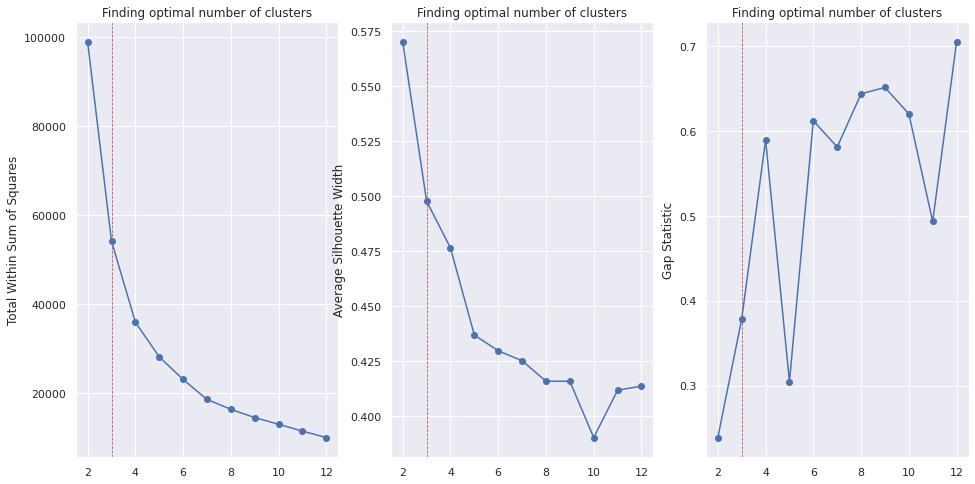

In [96]:
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,3,1)
ax.scatter(number_of_clusters,wss)
ax.plot(number_of_clusters,wss)
ax.set_ylabel('Total Within Sum of Squares')
ax.set_title('Finding optimal number of clusters')
ax.axvline(x=3,c='r',ls='--',lw=0.8)

ax=fig.add_subplot(1,3,2)
ax.scatter(number_of_clusters,ss)
ax.plot(number_of_clusters,ss)
ax.set_ylabel('Average Silhouette Width')
ax.set_title('Finding optimal number of clusters')
ax.axvline(x=3,c='r',ls='--',lw=0.8)

ax=fig.add_subplot(1,3,3)
ax.scatter(optimalK.gap_df['n_clusters'],optimalK.gap_df['gap_value'])
ax.plot(optimalK.gap_df['n_clusters'],optimalK.gap_df['gap_value'])
ax.set_ylabel('Gap Statistic')
ax.set_title('Finding optimal number of clusters')
ax.axvline(x=3,c='r',ls='--',lw=0.8)

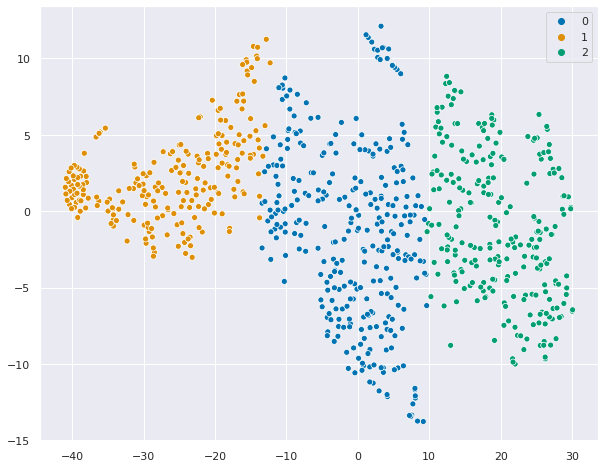

In [97]:
x_kmeans_3 = KMeans(n_clusters=3,random_state=1).fit(x_embedded)
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)
sns.scatterplot(x_embedded[:,0],x_embedded[:,1],x_kmeans_3.labels_,legend="full",palette="colorblind")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


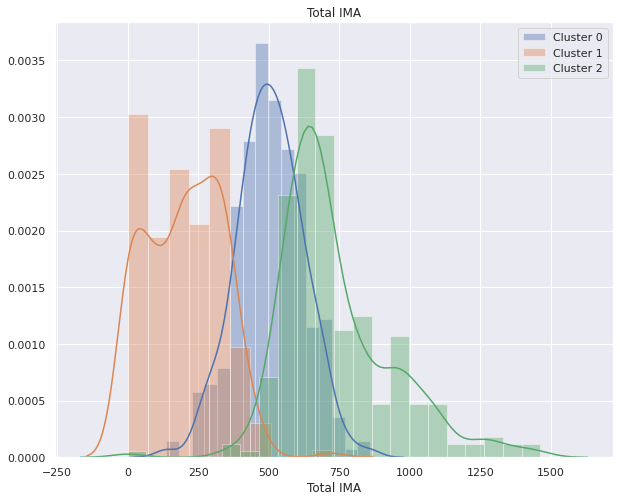

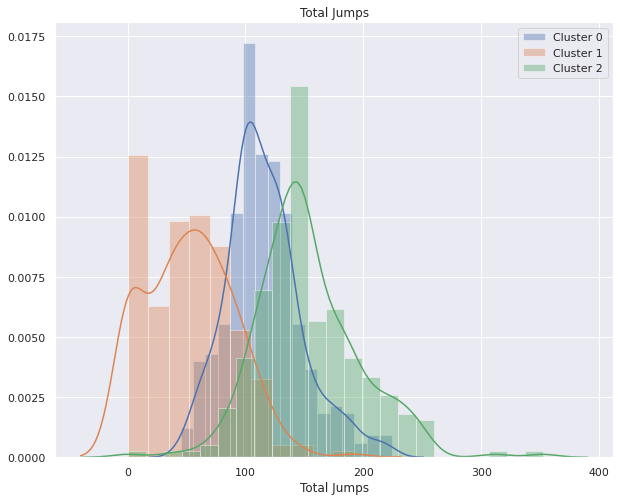

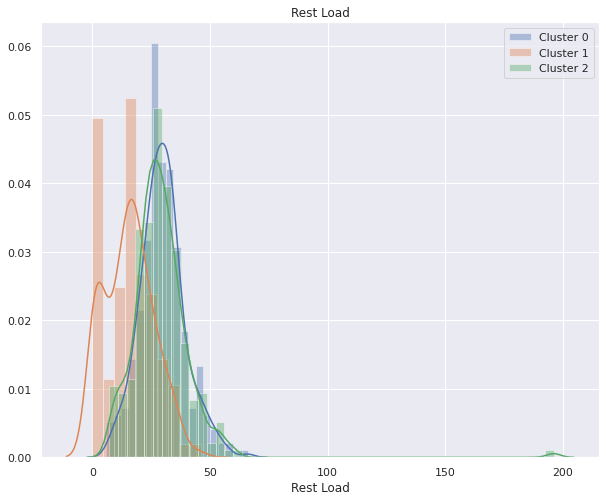

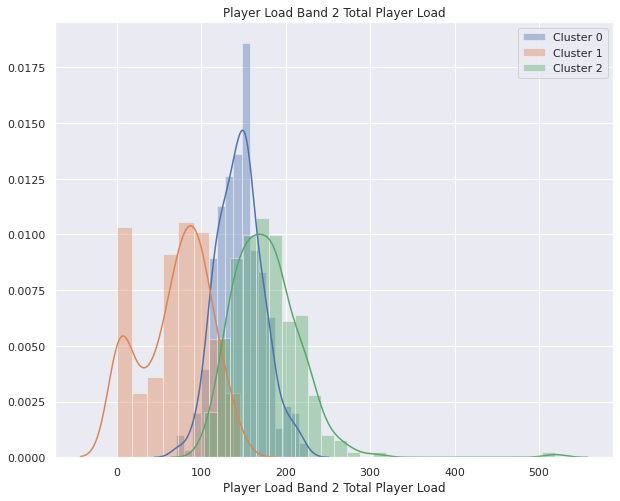

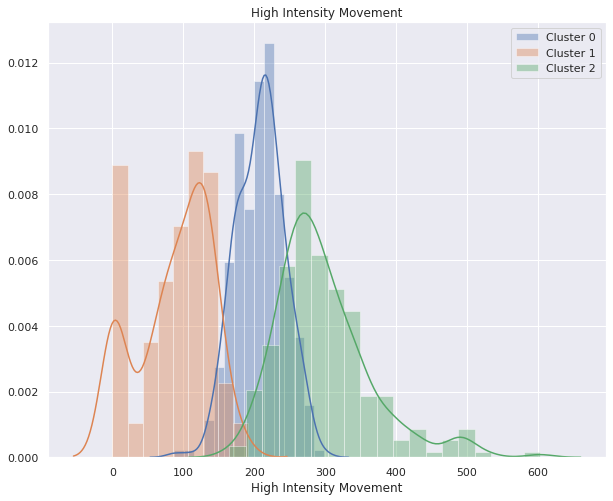

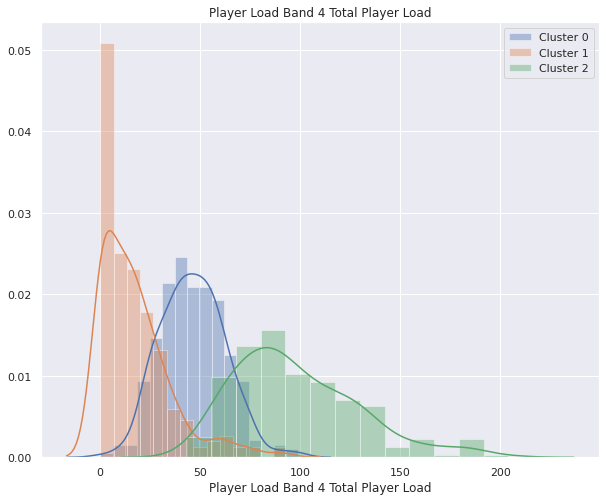

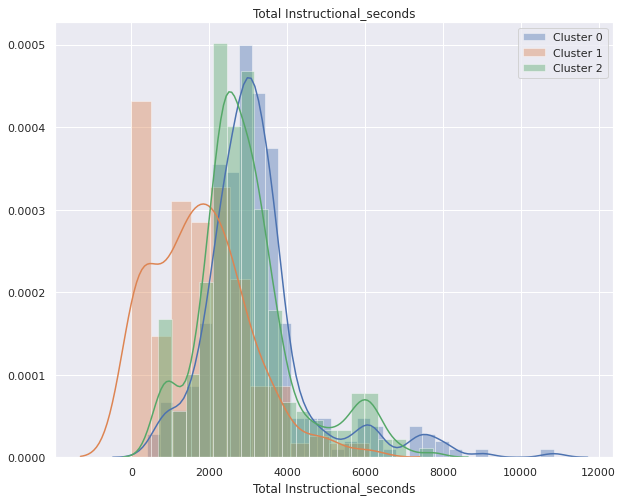

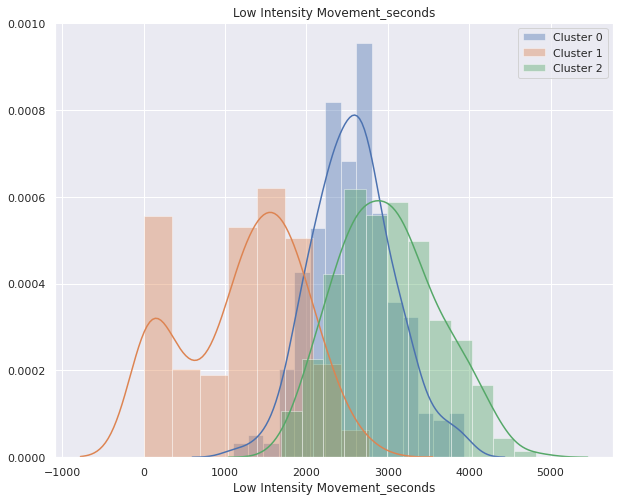

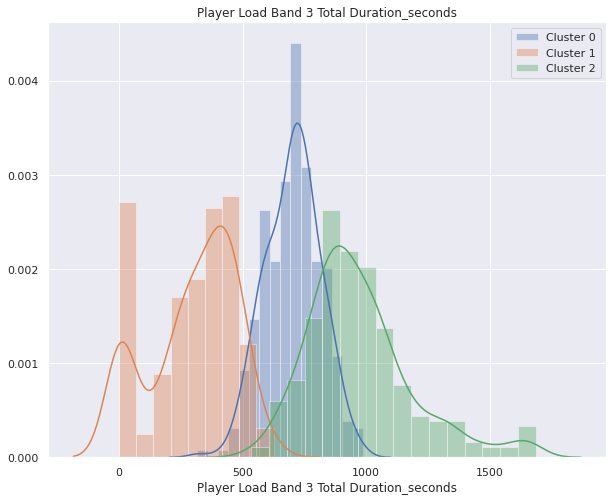

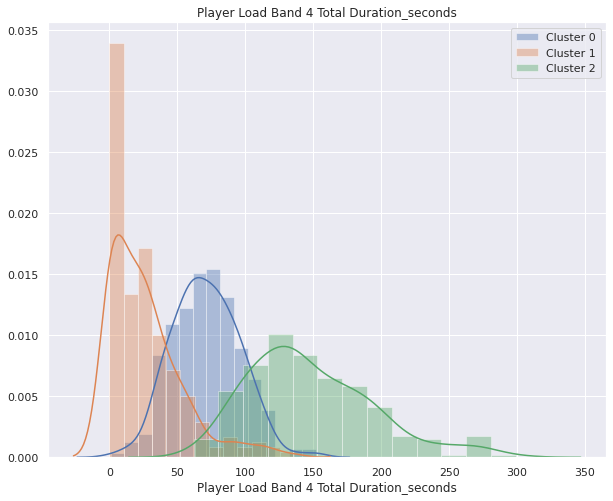

In [98]:
merged_game_catapult_practice_clusters['clusters']=x_kmeans_3.labels_
merged_game_catapult_practice['clusters']=x_kmeans_3.labels_
cluster_0=merged_game_catapult_practice_clusters[merged_game_catapult_practice_clusters['clusters']==0] 
cluster_1=merged_game_catapult_practice_clusters[merged_game_catapult_practice_clusters['clusters']==1]
cluster_2=merged_game_catapult_practice_clusters[merged_game_catapult_practice_clusters['clusters']==2]

for i,feat in enumerate(merged_game_catapult_practice_clusters.columns[:-1]):
  fig=plt.figure(figsize=(10,8))
  ax=fig.add_subplot(111)
  sns.distplot(cluster_0[feat],label='Cluster 0')
  sns.distplot(cluster_1[feat],label='Cluster 1')
  sns.distplot(cluster_2[feat],label='Cluster 2')
  ax.legend(loc='best')
  ax.set_title(feat)

In [0]:
cluster_0_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==0]
cluster_1_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==1]
cluster_2_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==2]

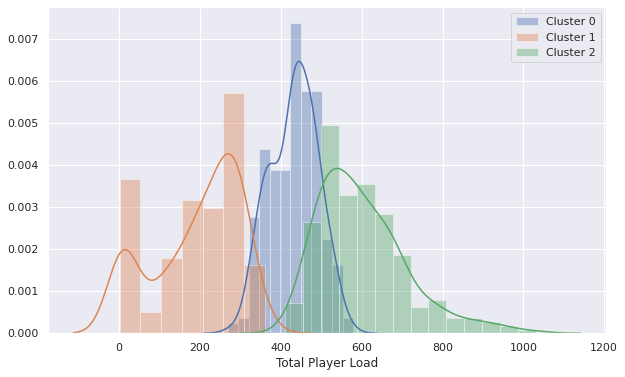

In [100]:
merged_game_catapult_practice['Total Player Load']
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
sns.distplot(cluster_0_full['Total Player Load'],label='Cluster 0')
sns.distplot(cluster_1_full['Total Player Load'],label='Cluster 1')
sns.distplot(cluster_2_full['Total Player Load'],label='Cluster 2')
ax.legend(loc='best')

In [101]:
wins_cluster_0=cluster_0_full['win']
wins_cluster_1=cluster_1_full['win']
wins_cluster_2=cluster_2_full['win']

cluster_0_counts=wins_cluster_0[wins_cluster_0==True].count()
cluster_1_counts=wins_cluster_1[wins_cluster_1==True].count()
cluster_2_counts=wins_cluster_2[wins_cluster_2==True].count()

total_wins=cluster_0_counts+cluster_1_counts+cluster_2_counts

print('Total win percentage : {} '.format(100*total_wins/len(merged_game_catapult_practice)))

print('Cluster 0 has {}% of the total wins'.format(100*cluster_0_counts/total_wins))
print('Cluster 1 has {}% of the total wins'.format(100*cluster_1_counts/total_wins))
print('Cluster 2 has {}% of the total wins'.format(100*cluster_2_counts/total_wins))

Total win percentage : 76.48546144121366 
Cluster 0 has 40.66115702479339% of the total wins
Cluster 1 has 29.09090909090909% of the total wins
Cluster 2 has 30.24793388429752% of the total wins


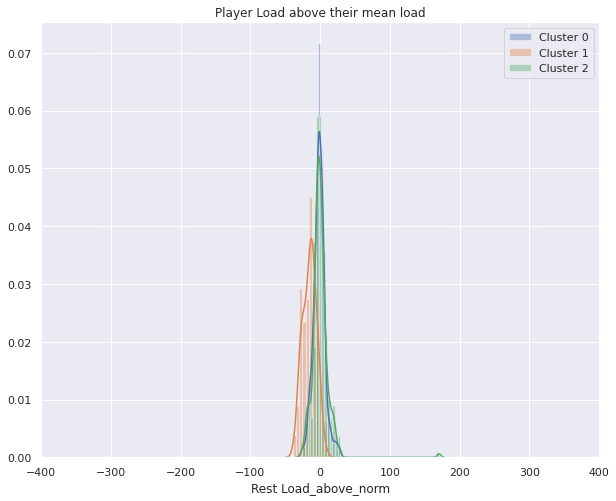

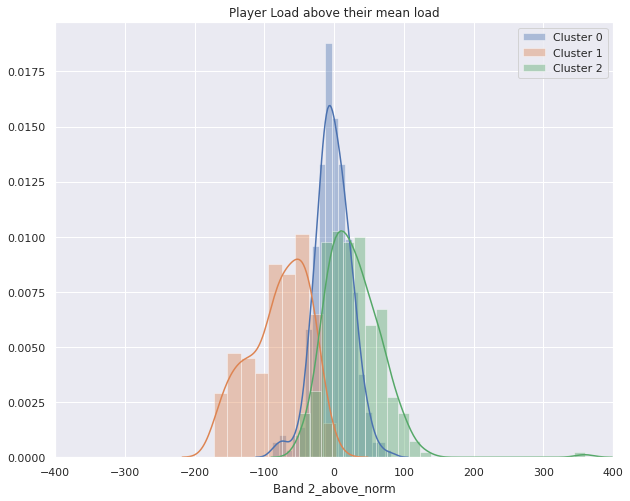

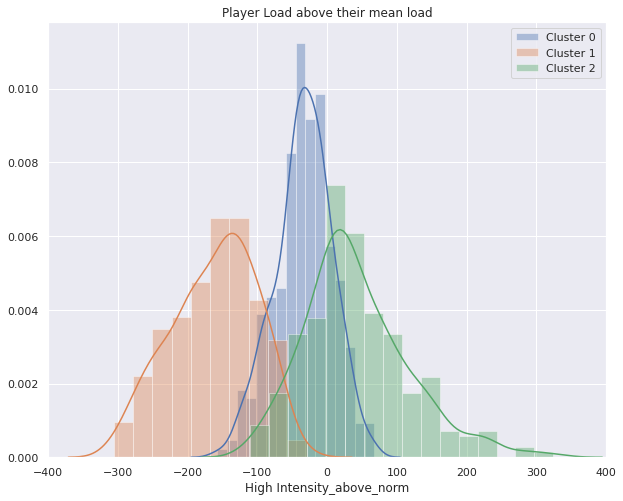

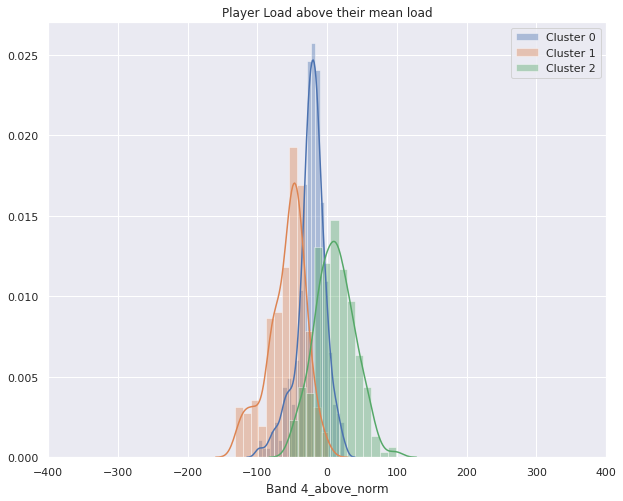

In [102]:
for cols in cols_above_mean_effort:
  fig=plt.figure(figsize=(10,8))
  ax=fig.add_subplot(111)
  sns.distplot(cluster_0_full[cols],label='Cluster 0')
  sns.distplot(cluster_1_full[cols],label='Cluster 1')
  sns.distplot(cluster_2_full[cols],label='Cluster 2')
  ax.set_title('Player Load above their mean load')
  ax.set_xlim(-400,400)
  ax.legend(loc='best')

# Testing out PCA embedding for reducing the dimensions of the data

In [0]:
#Taking in all the practice sessions
catapult_df_total_practice_game_features,catapult_cut_merge=merge_games_df_with_practice(catapult_df_total_practice,game_df)

col=catapult_df_total_practice_game_features.columns
col=col.delete(-1) #Deleting columns with duplicate names
col=col.delete(2) 
drop=catapult_df_total_practice_game_features[col]
drop=drop.reset_index(drop=True)
catapult_cut_merge=catapult_cut_merge.reset_index(drop=True)

merged_game_catapult_practice=pd.concat((catapult_cut_merge,drop),axis=1)

merged_game_catapult_practice_clusters=merged_game_catapult_practice[clustering_features]

# scaling all the Features
scaler=MinMaxScaler()
merged_game_catapult_practice_clusters_scaled = pd.DataFrame(scaler.fit_transform(merged_game_catapult_practice_clusters.values) \
                                                          , columns=merged_game_catapult_practice_clusters.columns, index=merged_game_catapult_practice_clusters)

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

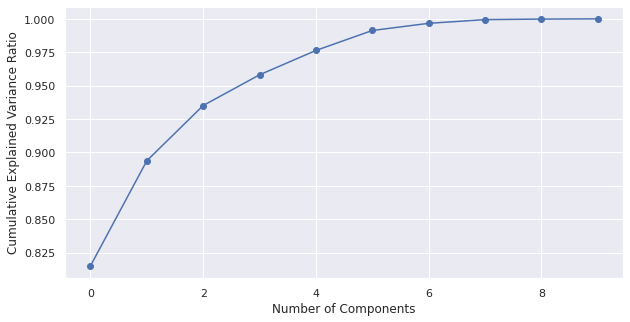

In [104]:
pca = PCA()
pca.fit(merged_game_catapult_practice_clusters_scaled)
plt.figure(figsize=(10, 5))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")

Total win percentage : 82.68053855569156 
Cluster 0 has 27.572168763878608% of the total wins
Cluster 1 has 44.189489267209474% of the total wins
Cluster 2 has 28.238341968911918% of the total wins


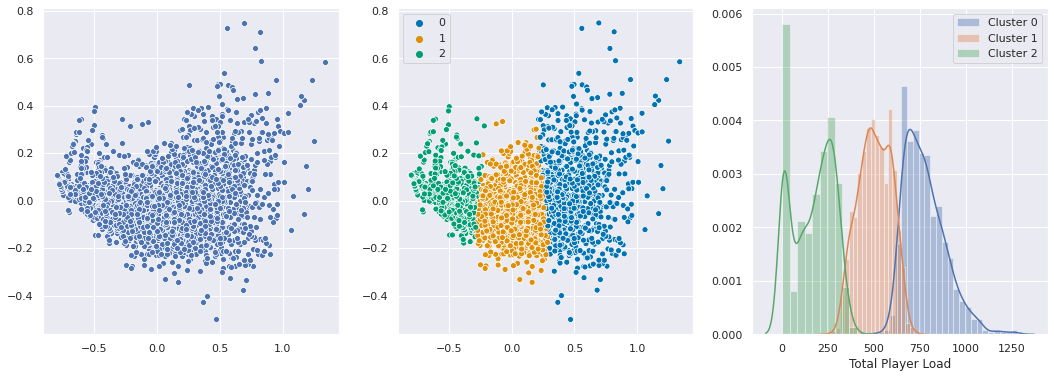

In [105]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(merged_game_catapult_practice_clusters_scaled)
fig=plt.figure(figsize=(18,6))
ax=fig.add_subplot(131)
sns.scatterplot(pca_result[:,0],pca_result[:,1])

x_kmeans_3=KMeans(n_clusters=3,random_state=1).fit(pca_result)
ax=fig.add_subplot(132)
sns.scatterplot(pca_result[:,0],pca_result[:,1],x_kmeans_3.labels_,legend="full",palette="colorblind")

merged_game_catapult_practice['clusters']=x_kmeans_3.labels_
cluster_0_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==0]
cluster_1_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==1]
cluster_2_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==2]

ax=fig.add_subplot(133)
sns.distplot(cluster_0_full['Total Player Load'],label='Cluster 0')
sns.distplot(cluster_1_full['Total Player Load'],label='Cluster 1')
sns.distplot(cluster_2_full['Total Player Load'],label='Cluster 2')
ax.legend(loc='best')

#Win percentage
wins_cluster_0=cluster_0_full['win']
wins_cluster_1=cluster_1_full['win']
wins_cluster_2=cluster_2_full['win']

cluster_0_counts=wins_cluster_0[wins_cluster_0==True].count()
cluster_1_counts=wins_cluster_1[wins_cluster_1==True].count()
cluster_2_counts=wins_cluster_2[wins_cluster_2==True].count()

total_wins=cluster_0_counts+cluster_1_counts+cluster_2_counts

print('Total win percentage : {} '.format(100*total_wins/len(merged_game_catapult_practice)))

print('Cluster 0 has {}% of the total wins'.format(100*cluster_0_counts/total_wins))
print('Cluster 1 has {}% of the total wins'.format(100*cluster_1_counts/total_wins))
print('Cluster 2 has {}% of the total wins'.format(100*cluster_2_counts/total_wins))

We get a little different result from PCA embedding- It tells us that very high loads are also not related to large wins. The optimum player load is between 250-750

## Testing out TSNE on PCA embedding

Total win percentage : 82.68053855569156 
Cluster 0 has 29.570688378978534% of the total wins
Cluster 1 has 37.934863064396744% of the total wins
Cluster 2 has 32.494448556624725% of the total wins


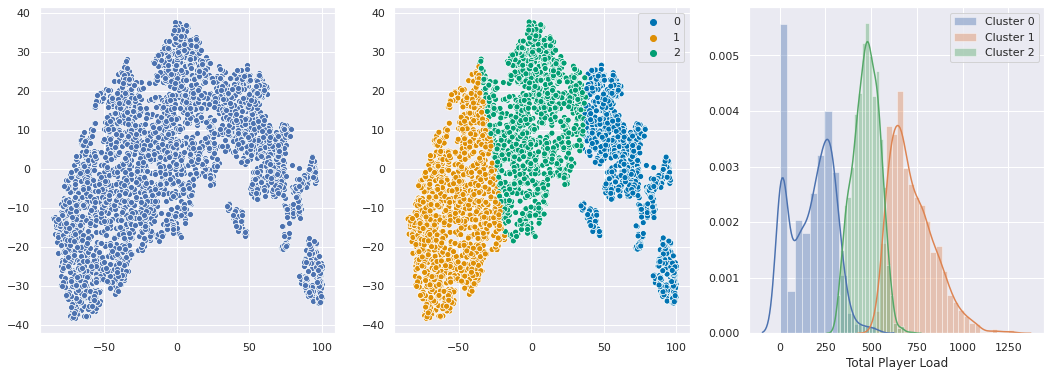

In [106]:
pca = PCA()
pca_result = pca.fit_transform(merged_game_catapult_practice_clusters_scaled)

pca_tsne = TSNE(n_components=2, perplexity=50, learning_rate=200.0, n_iter=5000).fit_transform(pca_result)

fig=plt.figure(figsize=(20,6))
ax=fig.add_subplot(131)
sns.scatterplot(pca_tsne[:,0],pca_tsne[:,1])

x_kmeans_3=KMeans(n_clusters=3,random_state=1).fit(pca_tsne)
ax=fig.add_subplot(132)
sns.scatterplot(pca_tsne[:,0],pca_tsne[:,1],x_kmeans_3.labels_,legend="full",palette="colorblind")

merged_game_catapult_practice['clusters']=x_kmeans_3.labels_
cluster_0_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==0]
cluster_1_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==1]
cluster_2_full=merged_game_catapult_practice[merged_game_catapult_practice['clusters']==2]

ax=fig.add_subplot(133)
sns.distplot(cluster_0_full['Total Player Load'],label='Cluster 0')
sns.distplot(cluster_1_full['Total Player Load'],label='Cluster 1')
sns.distplot(cluster_2_full['Total Player Load'],label='Cluster 2')
ax.legend(loc='best')

#Win percentage
wins_cluster_0=cluster_0_full['win']
wins_cluster_1=cluster_1_full['win']
wins_cluster_2=cluster_2_full['win']

cluster_0_counts=wins_cluster_0[wins_cluster_0==True].count()
cluster_1_counts=wins_cluster_1[wins_cluster_1==True].count()
cluster_2_counts=wins_cluster_2[wins_cluster_2==True].count()

total_wins=cluster_0_counts+cluster_1_counts+cluster_2_counts

print('Total win percentage : {} '.format(100*total_wins/len(merged_game_catapult_practice)))

print('Cluster 0 has {}% of the total wins'.format(100*cluster_0_counts/total_wins))
print('Cluster 1 has {}% of the total wins'.format(100*cluster_1_counts/total_wins))
print('Cluster 2 has {}% of the total wins'.format(100*cluster_2_counts/total_wins))

PCA-TSNE results are similar to TSNE results. Higher player loads during practice sessions are related to positive game outcomes.